In [201]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [249]:
def load_experiment_results(paths):
    """
    Load experiment results from given paths in the ccs_reporters_dir.
    Can handle paths to both individual experiment directories and sweep directories.

    Args:
    paths (list of str): Relative paths in the ccs_reporters_dir.

    Returns:
    pd.DataFrame: DataFrame with the experiment results.
    """
    root_dir = "/Users/elibronstein/Documents/academia/projects/LLM confidence calibration/eleuther-ccs/ccs-reporters"
    all_data = []

    for path in paths:
        full_path = os.path.join(root_dir, path)

        for dirpath, dirnames, filenames in os.walk(full_path):
            if "eval.csv" not in filenames:
                continue

            # Extract model and dataset from the path
            parts = dirpath.replace(root_dir, "").strip("/").split("/")

            if "transfer" in dirpath:
                eval_dataset = parts[-1]
                train_dataset = parts[-3]
                if len(parts) == 6:
                    model = parts[-4]
                elif len(parts) == 7:
                    model = os.path.join(*parts[-5:-3])
                else:
                    raise ValueError(f"Unexpected transfer path: {dirpath}")
            else:
                train_dataset = eval_dataset = parts[-1]
                if len(parts) == 4:
                    model = parts[-2]
                elif len(parts) == 5:
                    model = os.path.join(*parts[-3:-1])
                else:
                    raise ValueError(f"Unexpected path: {dirpath}")

            # Load eval.csv
            eval_df = pd.read_csv(os.path.join(dirpath, "eval.csv"))
            eval_df_dataset = eval_df["dataset"].unique()
            if len(eval_df_dataset) != 1:
                raise ValueError(
                    f"Expected one dataset in eval.csv, found {eval_df_dataset}"
                )
            eval_df_dataset = eval_df_dataset[0]
            del eval_df["dataset"]
            original_eval_df_columns = eval_df.columns.to_list()
            eval_df.columns = ["eval_" + col for col in eval_df.columns]

            # Load lr_eval.csv
            lr_eval_df = pd.read_csv(os.path.join(dirpath, "lr_eval.csv"))
            lr_eval_df_dataset = lr_eval_df["dataset"].unique()
            if len(lr_eval_df_dataset) != 1:
                raise ValueError(
                    f"Expected one dataset in lr_eval.csv, found {lr_eval_df_dataset}"
                )
            lr_eval_df_dataset = lr_eval_df_dataset[0]
            del lr_eval_df["dataset"]
            lr_eval_df.columns = ["lr_eval_" + col for col in lr_eval_df.columns]

            # Load lm_eval.csv if exists
            lm_eval_file = os.path.join(dirpath, "lm_eval.csv")
            if os.path.exists(lm_eval_file):
                lm_eval_df = pd.read_csv(lm_eval_file)
                lm_eval_df_dataset = lm_eval_df["dataset"].unique()
                if len(lm_eval_df_dataset) != 1:
                    raise ValueError(
                        f"Expected one dataset in lm_eval.csv, found {lm_eval_df_dataset}"
                    )
                lm_eval_df_dataset = lm_eval_df_dataset[0]
                del lm_eval_df["dataset"]
                lm_eval_df.columns = ["lm_eval_" + col for col in lm_eval_df.columns]
            else:
                lm_eval_df = pd.DataFrame(
                    columns=["lm_eval_" + col for col in original_eval_df_columns]
                )
                lm_eval_df.loc[0] = [pd.NA] * len(lm_eval_df.columns)
                lm_eval_df_dataset = None

            if not (
                (eval_dataset == eval_df_dataset == lr_eval_df_dataset)
                and (lm_eval_df_dataset is None or eval_dataset == lm_eval_df_dataset)
            ):
                raise ValueError(
                    "Expected one dataset in all eval CSV that matches the "
                    f"directory name, found {eval_df_dataset}, {lr_eval_df_dataset}, "
                    f"{lm_eval_df_dataset} for directory {dirpath}"
                )

            # Combine all dataframes
            combined_df = pd.concat([eval_df, lr_eval_df, lm_eval_df], axis=1)
            combined_df["model"] = model
            combined_df["dataset"] = train_dataset
            combined_df["eval_dataset"] = eval_dataset
            combined_df["path"] = dirpath.replace(root_dir, "").strip("/")

            all_data.append(combined_df)

    return pd.concat(all_data, ignore_index=True)


In [250]:
paths = [
    "sweeps/fervent-heisenberg",
    "sweeps/thirsty-wing",
    "sweeps/gallant-davinci",
]
results_df = load_experiment_results(paths)


In [251]:
results_df_without_transfer = results_df[results_df["dataset"] == results_df["eval_dataset"]]


In [72]:
# def load_experiment_results(paths):
#     """
#     Load experiment results from given paths in the ccs_reporters_dir.
#     Can handle paths to both individual experiment directories and sweep directories.

#     Args:
#     paths (list of str): Relative paths in the ccs_reporters_dir.

#     Returns:
#     pd.DataFrame: DataFrame with the experiment results.
#     """
#     root_dir = "/Users/elibronstein/Documents/academia/projects/LLM confidence calibration/eleuther-ccs/ccs-reporters"
#     all_data = []

#     for path in paths:
#         full_path = os.path.join(root_dir, path)

#         for dirpath, dirnames, filenames in os.walk(full_path):
#             # TODO: skipping transfer results for now.
#             if "transfer" in dirpath:
#                 continue
#             if "eval.csv" in filenames:
#                 # Extract model and dataset from the path
#                 parts = dirpath.replace(root_dir, '').strip('/').split('/')
#                 dataset = parts[-1]
#                 if len(parts) == 4:
#                     model = parts[-2]
#                 elif len(parts) == 5:
#                     model = os.path.join(*parts[-3:-1])
#                 else:
#                     raise ValueError(f"Unexpected path: {dirpath}")
#                 # print(f"Loading {model} on {dataset}")

#                 # Load eval.csv
#                 eval_df = pd.read_csv(os.path.join(dirpath, "eval.csv"))
#                 eval_df.columns = ['eval_' + col for col in eval_df.columns]

#                 # Load lr_eval.csv
#                 lr_eval_df = pd.read_csv(os.path.join(dirpath, "lr_eval.csv"))
#                 lr_eval_df.columns = ['lr_eval_' + col for col in lr_eval_df.columns]

#                 # Load lm_eval.csv if exists
#                 lm_eval_file = os.path.join(dirpath, "lm_eval.csv")
#                 if os.path.exists(lm_eval_file):
#                     lm_eval_df = pd.read_csv(lm_eval_file)
#                     lm_eval_df.columns = ['lm_eval_' + col for col in lm_eval_df.columns]
#                 else:
#                     lm_eval_df = pd.DataFrame(columns=['lm_eval_' + col for col in eval_df.columns])
#                     lm_eval_df.loc[0] = [pd.NA] * len(lm_eval_df.columns)

#                 # Combine all dataframes
#                 combined_df = pd.concat([eval_df, lr_eval_df, lm_eval_df], axis=1)
#                 combined_df['model'] = model
#                 combined_df['dataset'] = dataset
#                 combined_df['path'] = dirpath.replace(root_dir, '').strip('/')

#                 all_data.append(combined_df)

#     return pd.concat(all_data, ignore_index=True)


## get_best_metric_per_model_and_dataset

In [253]:
def get_best_metric_per_model_and_dataset(df, metric: str, layer=None, ensembling=None):
    metric_options = ["acc_estimate", "cal_acc_estimate", "auroc_estimate", "ece"]
    if metric not in metric_options:
        raise ValueError(f"Invalid metric. Must be one of {metric_options}")
    # If layer is specified, filter by layer
    if layer is not None:
        df = df[
            (df["eval_layer"] == layer)
            & (df["lr_eval_layer"] == layer)
            & (df["lm_eval_layer"] == layer)
        ]
    # If ensembling is specified, filter by ensembling
    if ensembling is not None:
        df = df[
            (df["eval_ensembling"] == ensembling)
            & (df["lr_eval_ensembling"] == ensembling)
            & (
                (df["lm_eval_ensembling"] == ensembling)
                | df["lm_eval_ensembling"].isna()
            )
        ]
    # Group by model and dataset, and take the min if ECE, max if accuracy or AUROC.
    grouped_df = df.groupby(["model", "dataset"])
    grouped_df = grouped_df.min() if metric == "ece" else grouped_df.max()
    return grouped_df


In [231]:
def plot_grouped_accuracy_by_model_with_labels(
    df, layer=None, ensembling=None, metric: str = "acc_estimate"
):
    """
    Creates a figure with subplots for each model showing grouped bar plots
    of the average accuracy of CCS, LR, and Zero-Shot for each dataset, with accuracy labels on top of each bar.

    Args:
        df (pd.DataFrame): DataFrame with experiment results.
        metric: "acc_estimate", "cal_acc_estimate", "auroc_estimate", "ece".
    """
    metric_options = ["acc_estimate", "cal_acc_estimate", "auroc_estimate", "ece"]
    if metric not in metric_options:
        raise ValueError(f"Invalid metric. Must be one of {metric_options}")

    metric_cols = [f"{method}_{metric}" for method in ["eval", "lr_eval", "lm_eval"]]
    method_mapping = {k: v for k, v in zip(metric_cols, ["CCS", "LR", "Zero-Shot"])}

    # Filter relevant columns
    df = df[
        [
            "model",
            "dataset",
            *metric_cols,
            "eval_layer",
            "lr_eval_layer",
            "lm_eval_layer",
            "eval_ensembling",
            "lr_eval_ensembling",
            "lm_eval_ensembling",
        ]
    ]

    grouped_df = get_best_metric_per_model_and_dataset(
        df, metric, layer=layer, ensembling=ensembling
    ).reset_index()

    # Find unique models
    models = grouped_df["model"].unique()

    # Set seaborn style for plots
    plt.style.use("seaborn-v0_8-paper")

    # Create subplots
    fig, axes = plt.subplots(1, len(models), figsize=(5 * len(models), 5), sharex=True)

    if len(models) == 1:
        axes = [axes]  # Ensure axes is always a list

    # Create a color palette
    palette = ["blue", "orange", "green"]

    for ax, model in zip(axes, models):
        # Filter data for this model
        model_df = grouped_df[grouped_df["model"] == model]

        # Melt the DataFrame for easy plotting
        melted_df = model_df.melt(
            id_vars=["model", "dataset"],
            value_vars=metric_cols,
            var_name="method",
            value_name="metric",
        )

        # Map methods to more readable names
        melted_df["method"] = melted_df["method"].map(method_mapping)

        # Plot grouped bar plot
        bars = sns.barplot(
            data=melted_df,
            x="dataset",
            y="metric",
            hue="method",
            palette=palette,
            ax=ax,
        )

        # Add text labels on top of each bar
        for bar in bars.patches:
            bars.annotate(
                format(bar.get_height(), ".2f"),
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha="center",
                va="center",
                size=9,
                xytext=(0, 8),
                textcoords="offset points",
            )

        ax.set_title(f"Model: {model}")
        ax.set_ylabel(metric)
        ax.set_xlabel("")

    # Add legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=3)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()


Ensembling: none


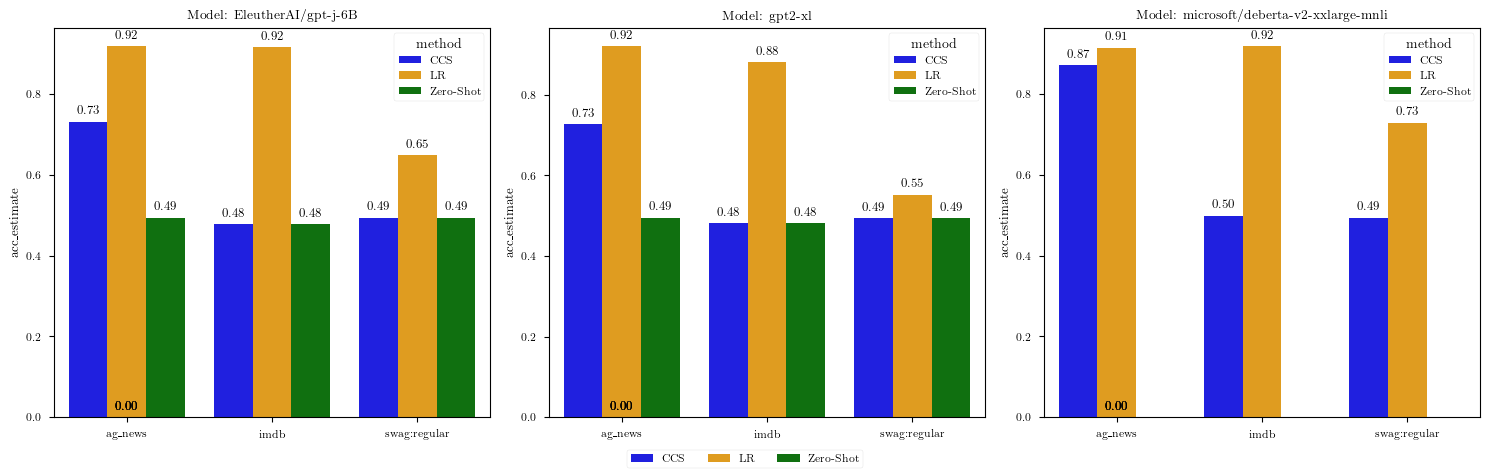

Ensembling: none


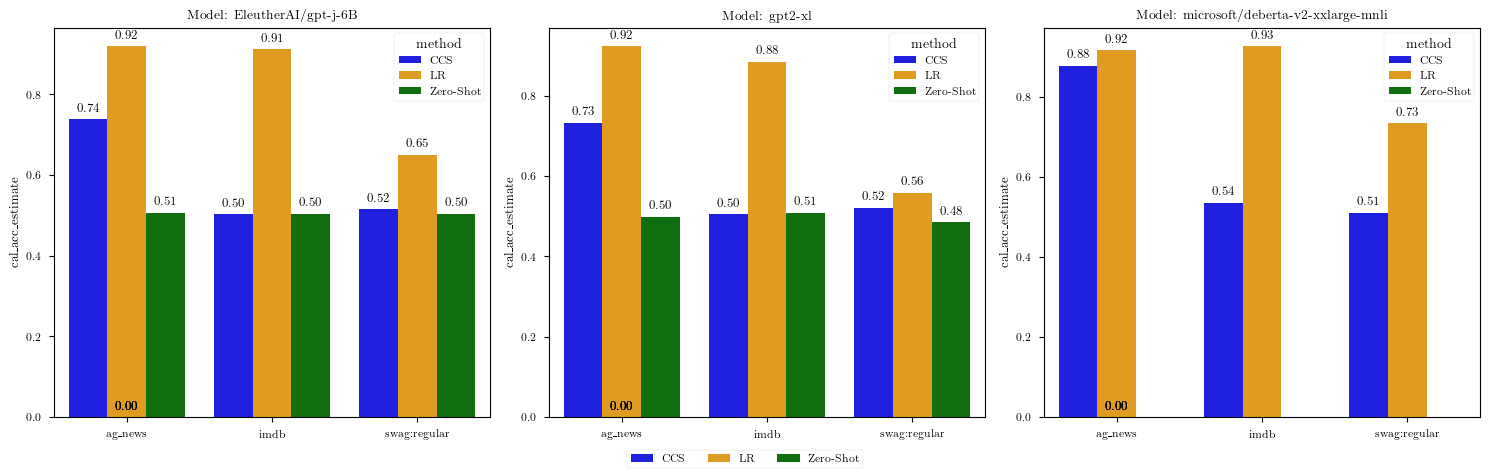

Ensembling: none


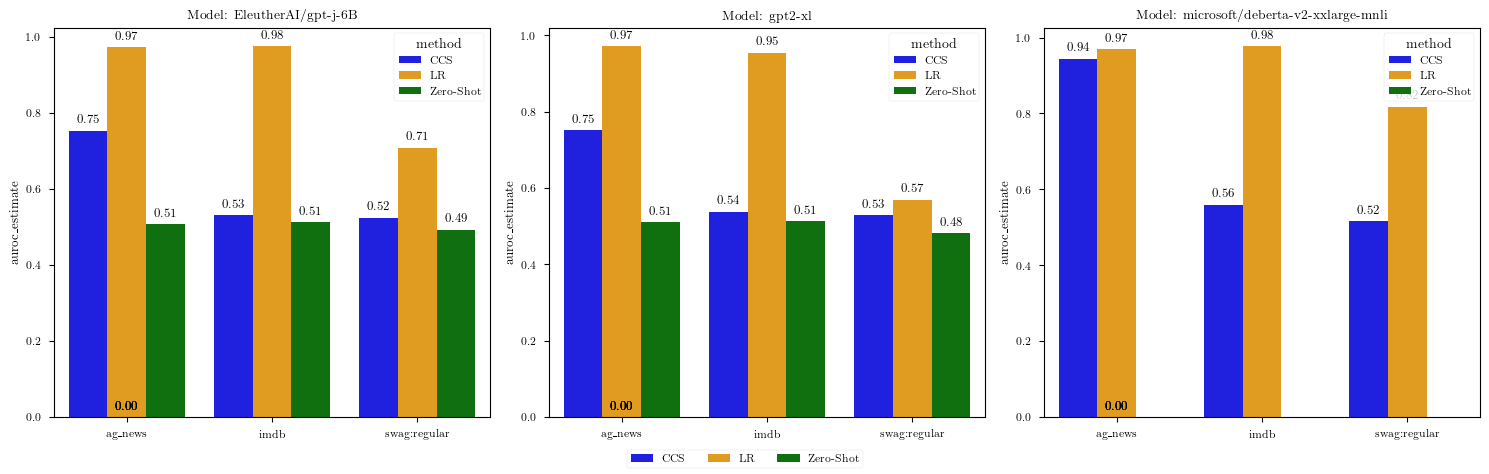

Ensembling: none


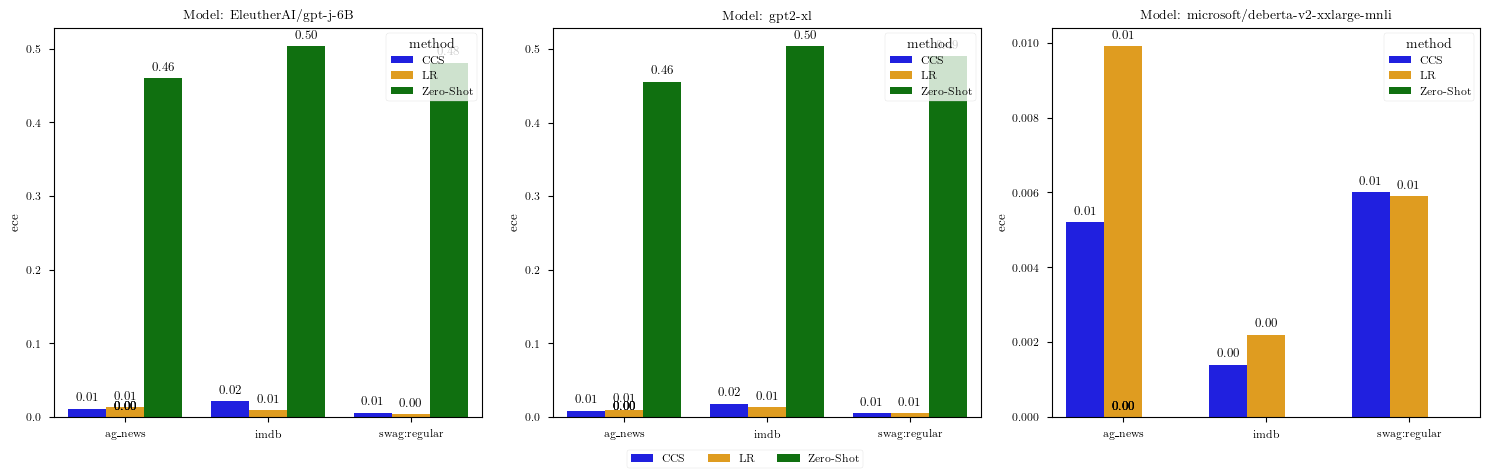

Ensembling: partial


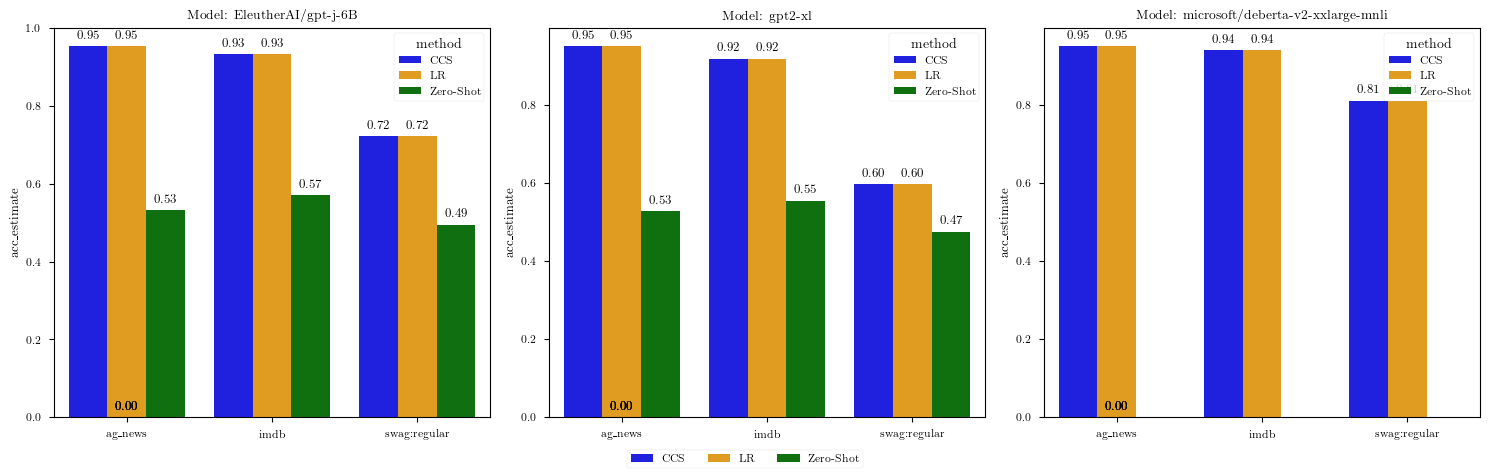

Ensembling: partial


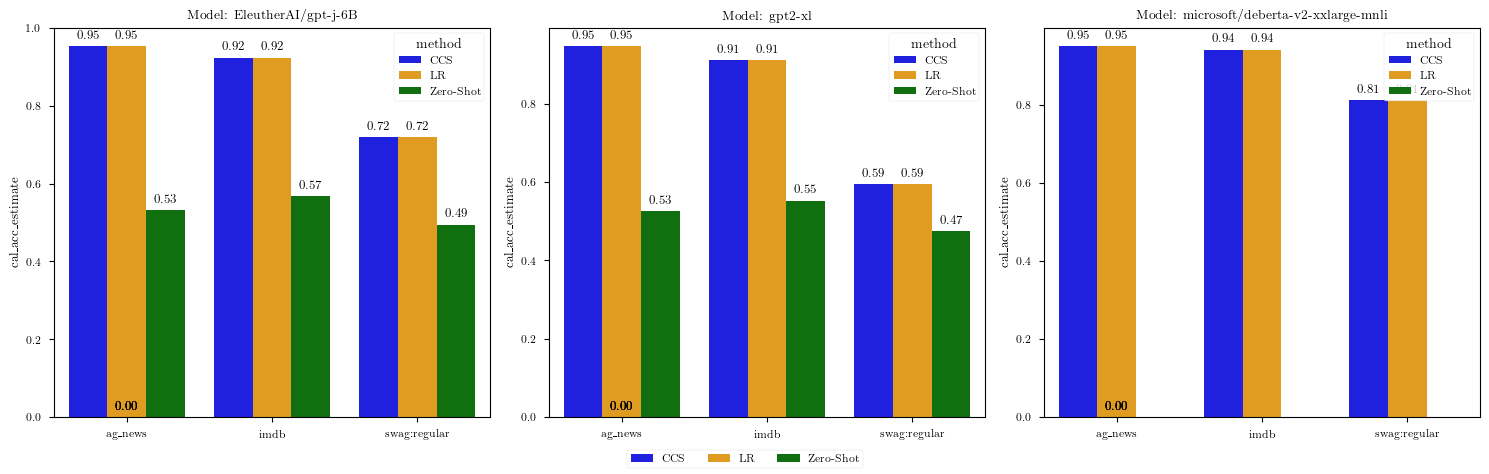

Ensembling: partial


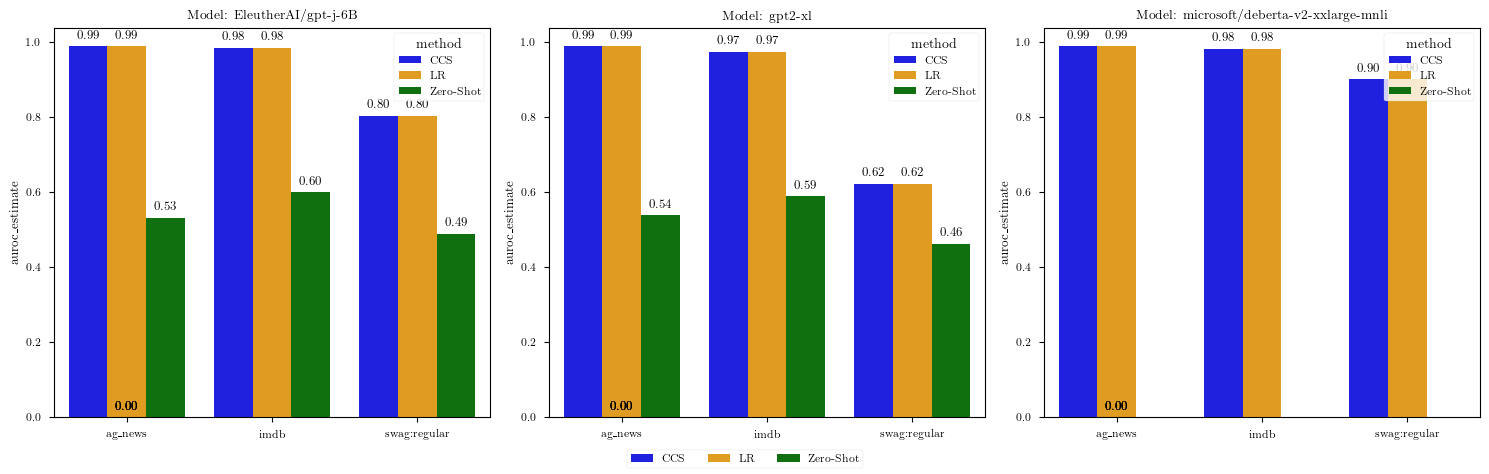

Ensembling: partial


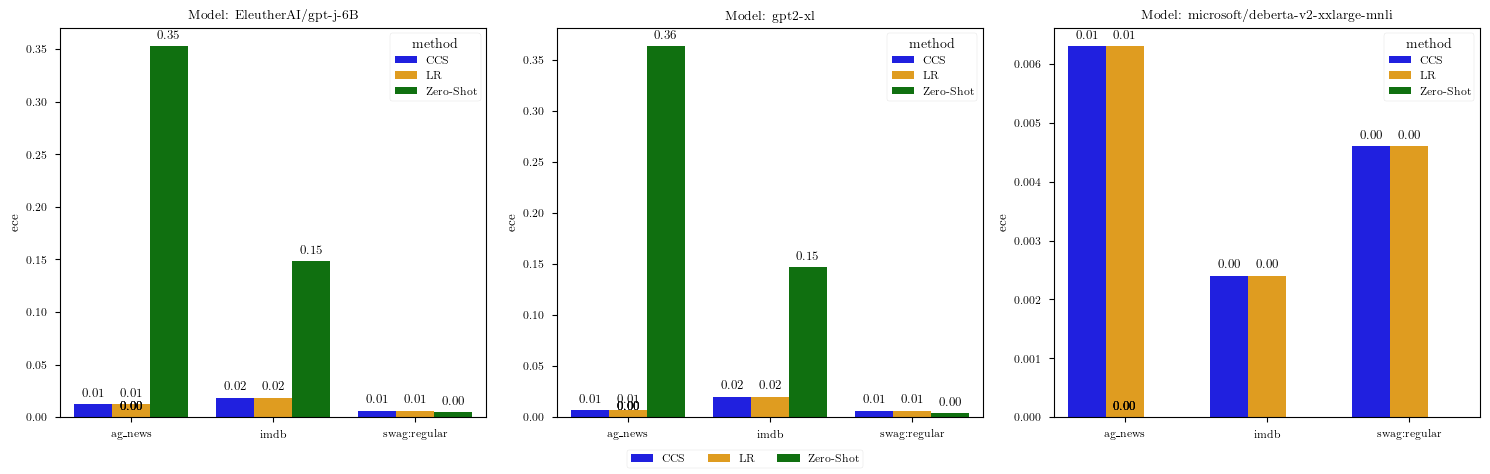

Ensembling: full


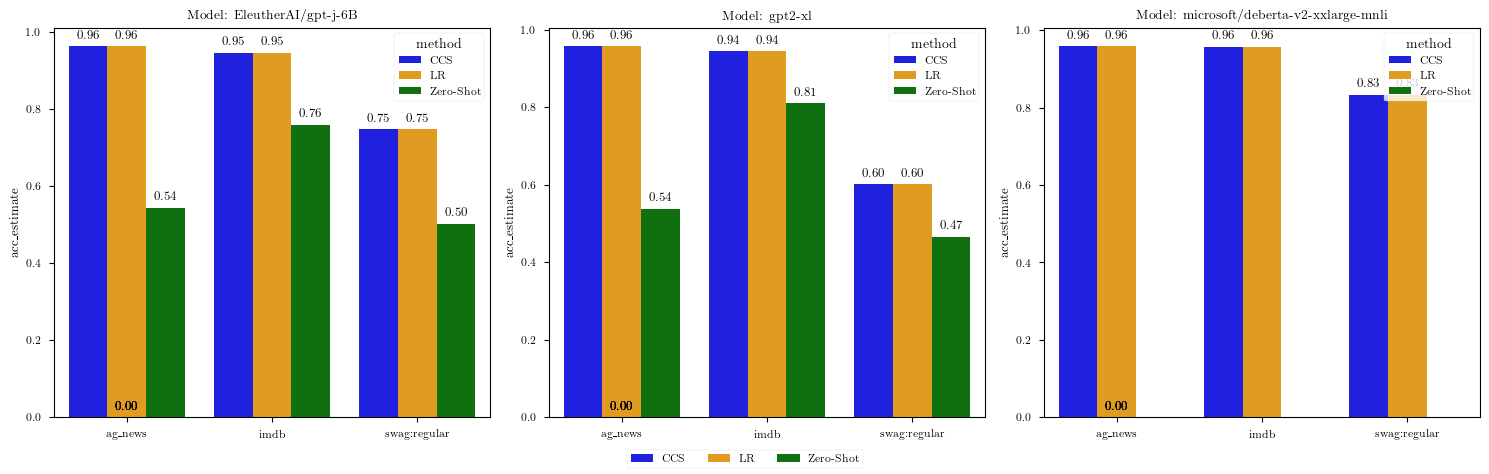

Ensembling: full


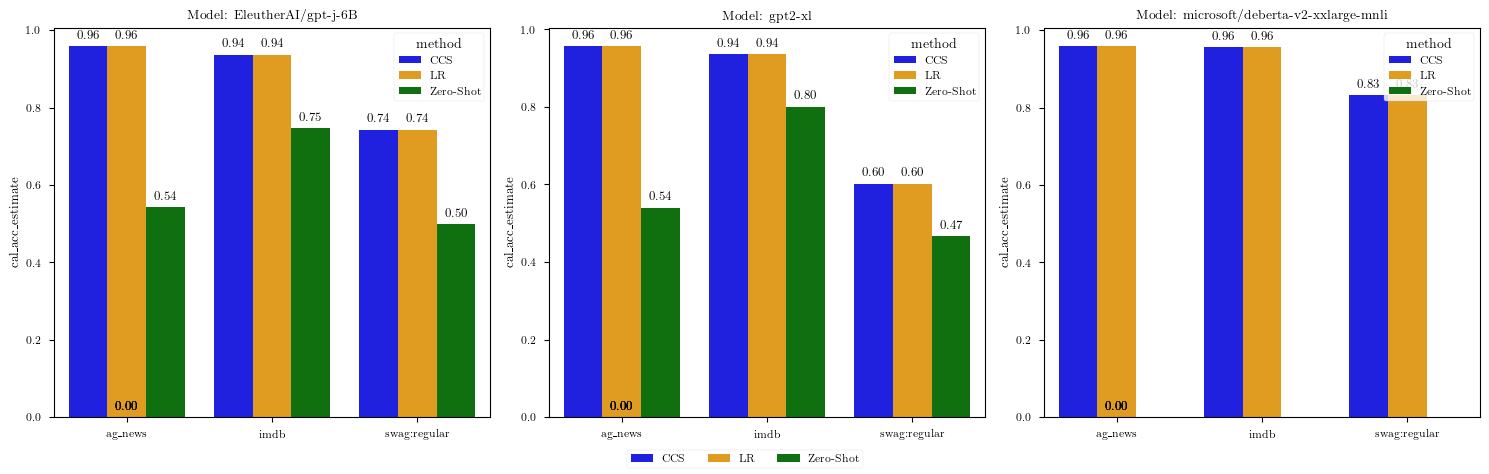

Ensembling: full


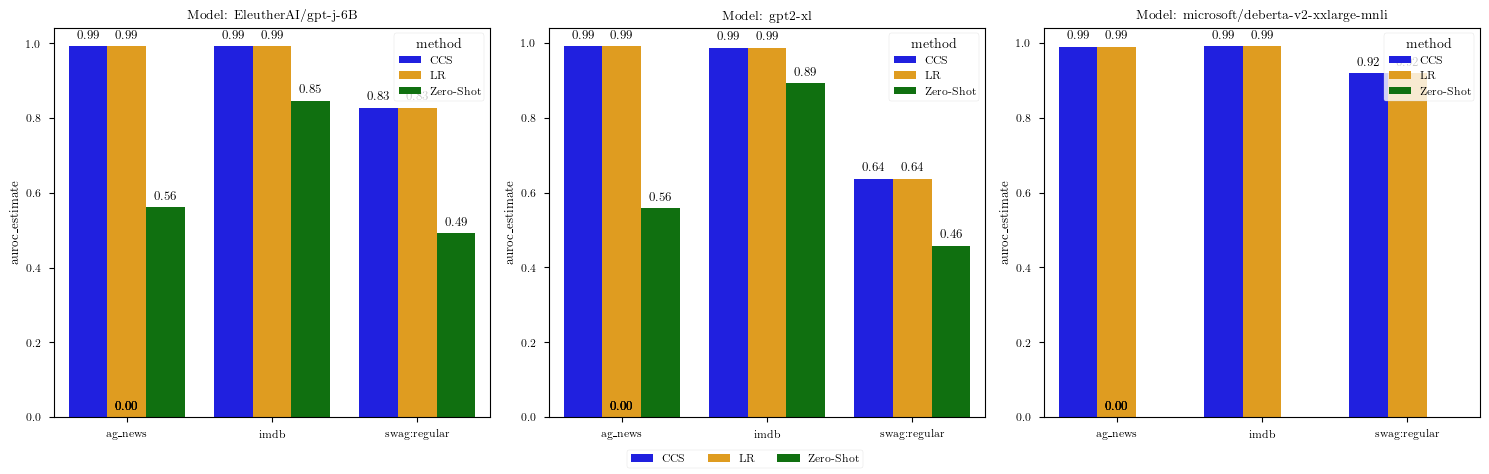

Ensembling: full


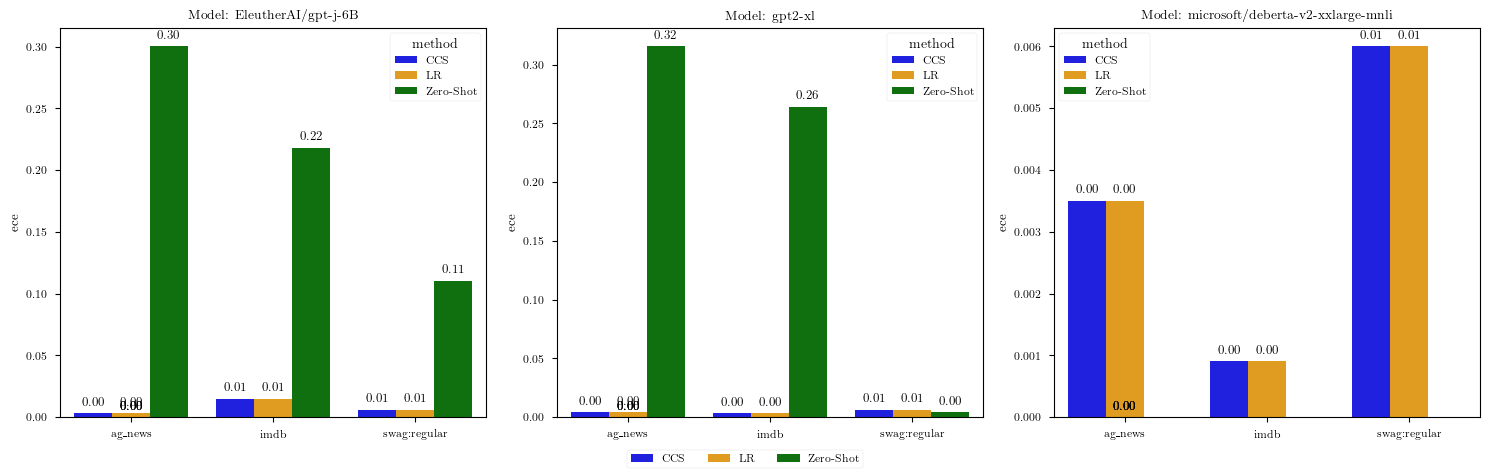

In [232]:
for ensembling in ["none", "partial", "full"]:
    for metric in ["acc_estimate", "cal_acc_estimate", "auroc_estimate", "ece"]:
        print(f"Ensembling: {ensembling}")
        plot_grouped_accuracy_by_model_with_labels(
            results_df_without_transfer, layer=None, ensembling=ensembling, metric=metric
        )


In [233]:
def plot_mean_metric_by_model_with_labels(
    df, layer=None, ensembling=None, metric: str = "acc_estimate"
):
    """
    Creates a figure showing grouped bar plots of the average metric of CCS, LR,
    and Zero-Shot averaged over all the datasets, with labels on top of each bar.

    Args:
        df (pd.DataFrame): DataFrame with experiment results.
        metric: "acc_estimate", "cal_acc_estimate", "auroc_estimate", "ece".
    """
    metric_options = ["acc_estimate", "cal_acc_estimate", "auroc_estimate", "ece"]
    if metric not in metric_options:
        raise ValueError(f"Invalid metric. Must be one of {metric_options}")

    metric_cols = [f"{method}_{metric}" for method in ["eval", "lr_eval", "lm_eval"]]
    method_mapping = {k: v for k, v in zip(metric_cols, ["CCS", "LR", "Zero-Shot"])}

    # Filter relevant columns
    df = df[
        [
            "model",
            "dataset",
            *metric_cols,
            "eval_layer",
            "lr_eval_layer",
            "lm_eval_layer",
            "eval_ensembling",
            "lr_eval_ensembling",
            "lm_eval_ensembling",
        ]
    ]

    # Group by model and dataset, and get the best metric results.
    grouped_df = get_best_metric_per_model_and_dataset(
        df, metric, layer=layer, ensembling=ensembling
    )
    # Average over datasets.
    grouped_df = grouped_df.groupby(["model"]).mean(numeric_only=True)
    # If there is only one model, grouped_df is a single row as a pd.Series. Conver it to a
    # one-row DataFrame.
    if isinstance(grouped_df, pd.Series):
        grouped_df = pd.DataFrame([grouped_df])

    grouped_df = grouped_df.reset_index()

    # Find unique models
    models = grouped_df["model"].unique()

    # Set seaborn style for plots
    plt.style.use("seaborn-v0_8-paper")

    # Create subplots
    fig, ax = plt.subplots(
        1, 1, figsize=(3 * len(models), 5), sharex=True, squeeze=True
    )

    # Create a color palette
    palette = ["blue", "orange", "green"]

    # Melt the DataFrame for easy plotting
    melted_df = grouped_df.melt(
        id_vars=["model"],
        value_vars=metric_cols,
        var_name="method",
        value_name="metric",
    )

    # Map methods to more readable names
    melted_df["method"] = melted_df["method"].map(method_mapping)

    # Plot grouped bar plot
    bars = sns.barplot(
        data=melted_df,
        x="model",
        y="metric",
        hue="method",
        palette=palette,
        ax=ax,
    )

    # Add text labels on top of each bar
    for bar in bars.patches:
        bars.annotate(
            format(bar.get_height(), ".2f"),
            (bar.get_x() + bar.get_width() / 2, bar.get_height()),
            ha="center",
            va="center",
            size=9,
            xytext=(0, 8),
            textcoords="offset points",
        )

    ax.set_ylabel(metric)
    ax.set_xlabel("Model")

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=3)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()


Ensembling: none


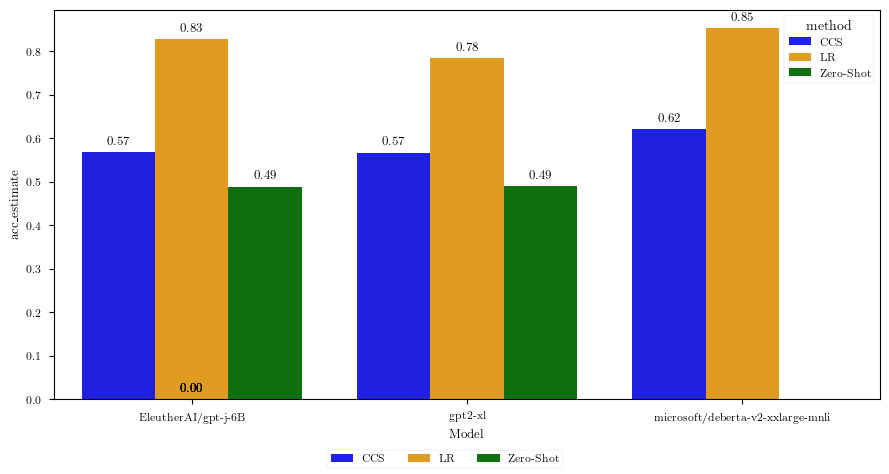

Ensembling: none


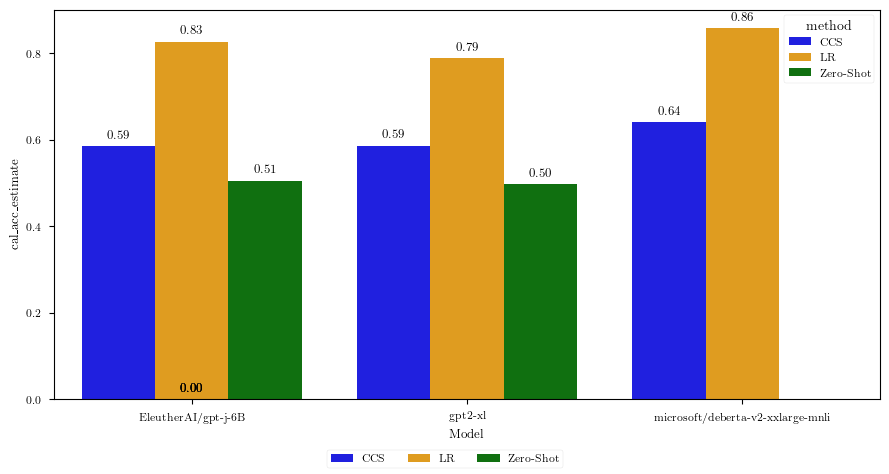

Ensembling: none


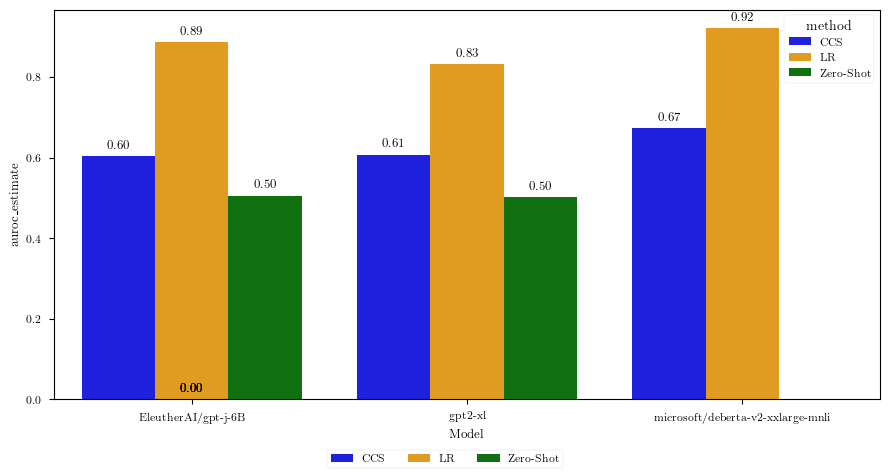

Ensembling: none


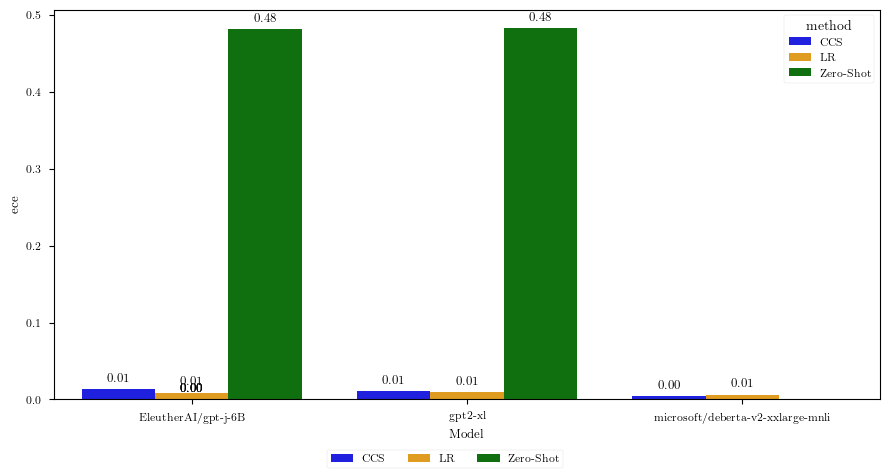

Ensembling: partial


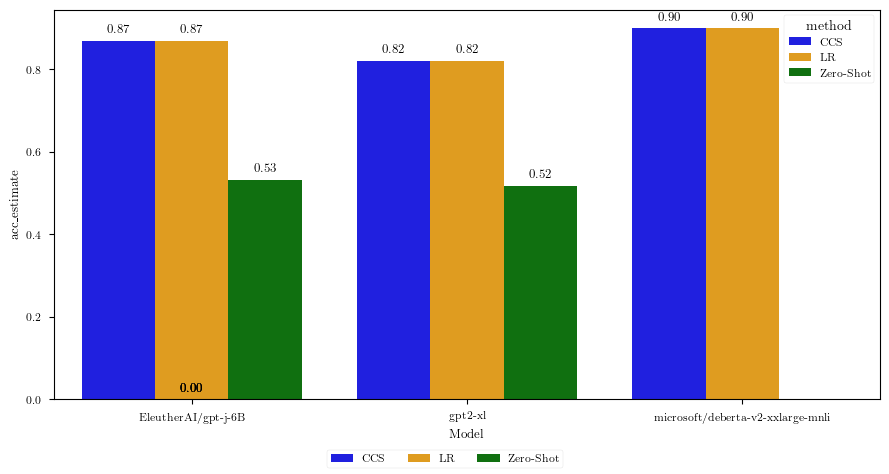

Ensembling: partial


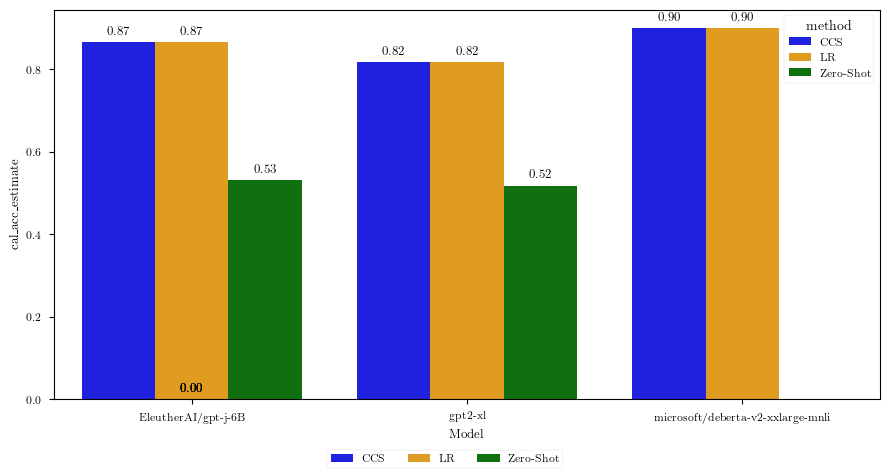

Ensembling: partial


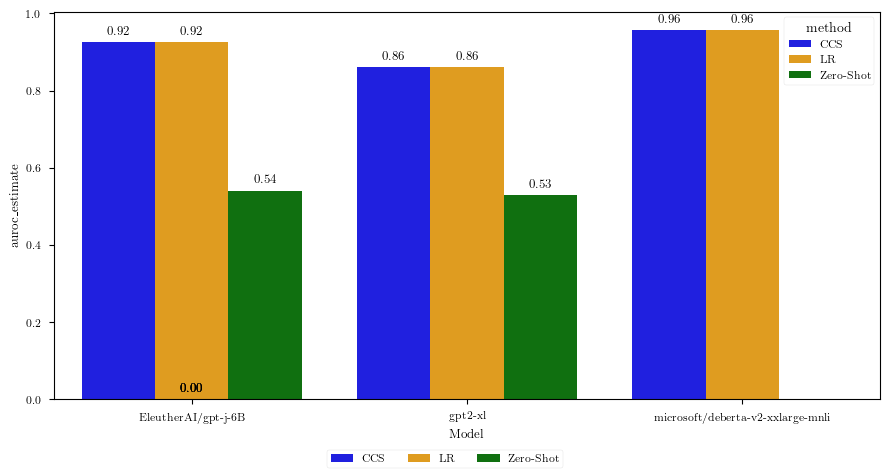

Ensembling: partial


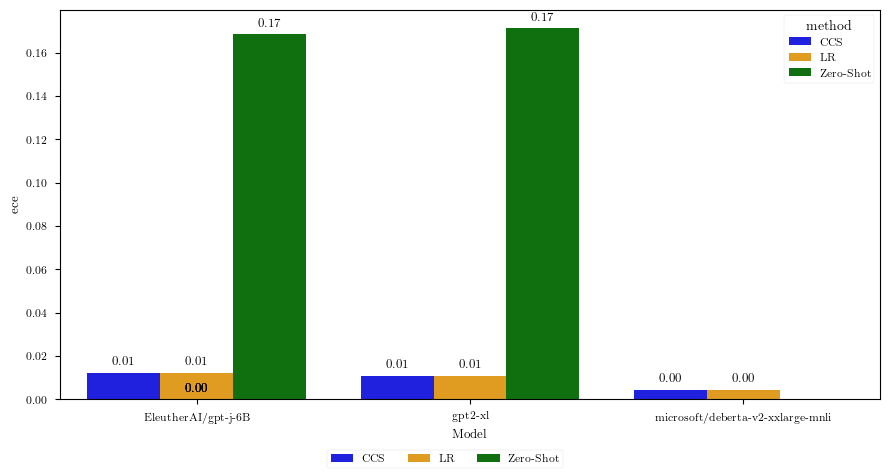

Ensembling: full


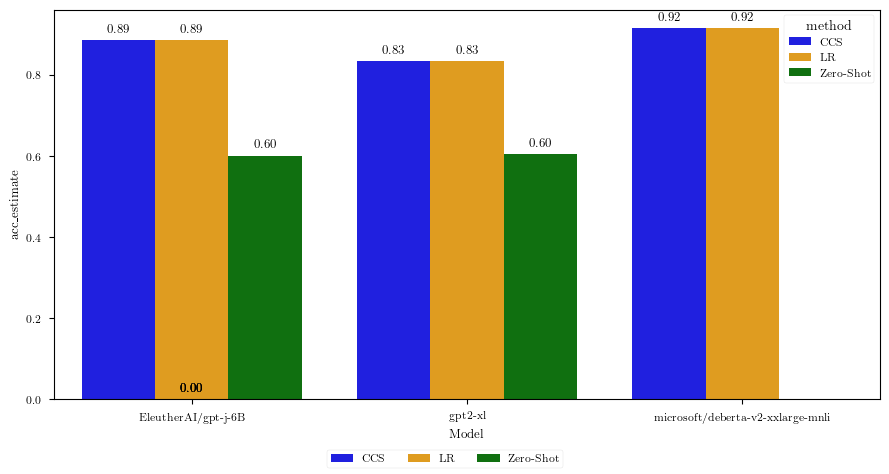

Ensembling: full


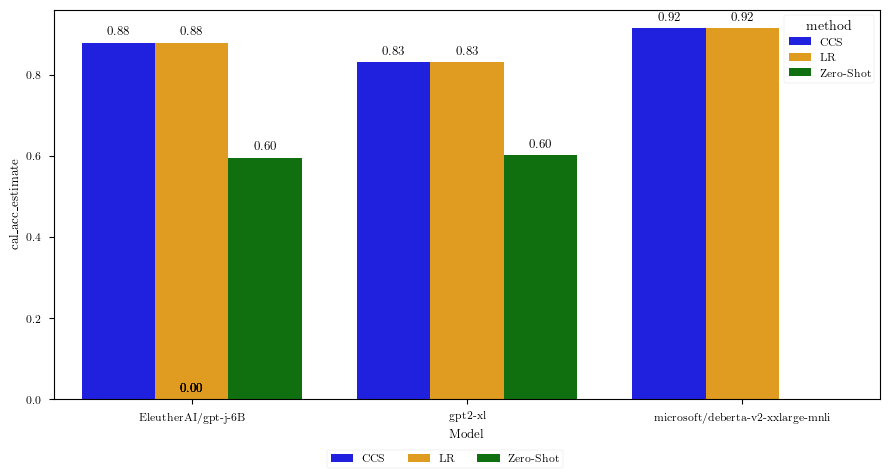

Ensembling: full


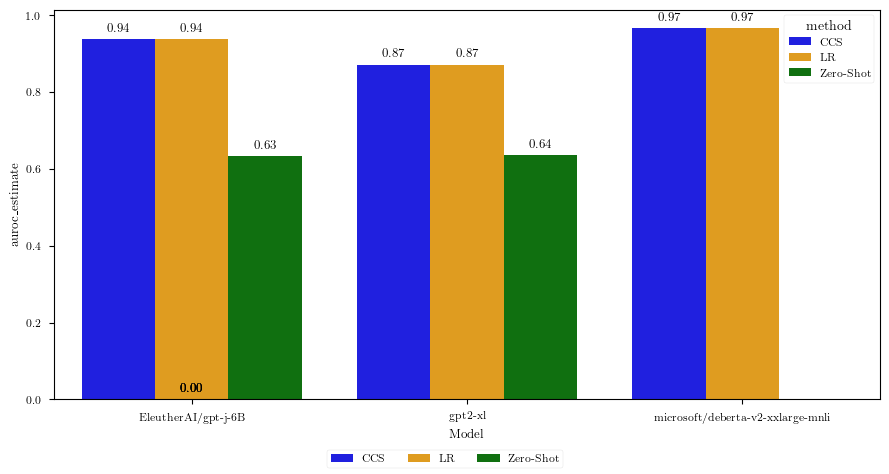

Ensembling: full


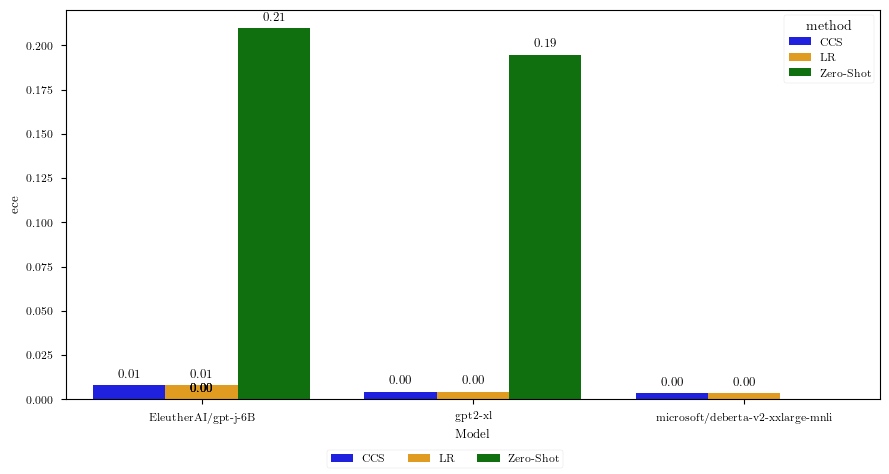

In [234]:
for ensembling in ["none", "partial", "full"]:
    for metric in ["acc_estimate", "cal_acc_estimate", "auroc_estimate", "ece"]:
        print(f"Ensembling: {ensembling}")
        plot_mean_metric_by_model_with_labels(results_df_without_transfer, layer=None, ensembling=ensembling, metric=metric)


In [235]:
def plot_metric_vs_layer(results_df, ensembling=None, metric="auroc_estimate"):
    metric_options = ["acc_estimate", "cal_acc_estimate", "auroc_estimate", "ece"]
    if metric not in metric_options:
        raise ValueError(f"Invalid metric. Must be one of {metric_options}")

    metric_cols = [f"{method}_{metric}" for method in ["eval", "lr_eval", "lm_eval"]]
    method_mapping = {k: v for k, v in zip(metric_cols, ["CCS", "LR", "Zero-Shot"])}

    # Filter relevant columns
    df = results_df[
        [
            "model",
            "dataset",
            *metric_cols,
            "eval_layer",
            "lr_eval_layer",
            "lm_eval_layer",
            "eval_ensembling",
            "lr_eval_ensembling",
            "lm_eval_ensembling",
        ]
    ]

    # If ensembling is specified, filter by ensembling
    if ensembling is not None:
        df = df[
            (df["eval_ensembling"] == ensembling)
            & (df["lr_eval_ensembling"] == ensembling)
            & (
                (df["lm_eval_ensembling"] == ensembling)
                | df["lm_eval_ensembling"].isna()
            )
        ]

    # Group by model and dataset, take the min/max, then average over the datasets.
    grouped_df = (
        df.groupby(["model", "dataset", "eval_layer"]))
    grouped_df = grouped_df.min() if metric == "ece" else grouped_df.max()
    grouped_df = grouped_df(
        .groupby(["model", "eval_layer"])
        .mean(numeric_only=True)
    )
    # If there is only one model, grouped_df is a single row as a pd.Series. Conver it to a
    # one-row DataFrame.
    if isinstance(grouped_df, pd.Series):
        grouped_df = pd.DataFrame([grouped_df])

    grouped_df = grouped_df.reset_index()

    # Find unique models
    models = grouped_df["model"].unique()

    # Set seaborn style for plots
    plt.style.use("seaborn-v0_8-paper")

    # Create a color palette (one color per method - CCS, LR, Zero-Shot)
    palette = ["blue", "orange", "green"]

    # Create subplots
    fig, axes = plt.subplots(
        1, len(models), figsize=(3 * len(models), 5), sharex=False, sharey=True
    )

    if len(models) == 1:
        axes = [axes]  # Ensure axes is always a list

    for ax, model in zip(axes, models):
        # Filter data for this model
        model_df = grouped_df[grouped_df["model"] == model]

        # Melt the DataFrame for easy plotting
        melted_df = model_df.melt(
            id_vars=["model", "eval_layer"],
            value_vars=metric_cols,
            var_name="method",
            value_name="metric",
        )

        # Map methods to more readable names
        melted_df["method"] = melted_df["method"].map(method_mapping)

        # Plot line plot
        bars = sns.lineplot(
            data=melted_df,
            x="eval_layer",
            y="metric",
            hue="method",
            palette=palette,
            ax=ax,
        )

        ax.set_title(model)
        ax.set_ylabel(metric)
        ax.set_xlabel("Layer")

    # Add legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=3)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()


SyntaxError: invalid syntax (1821680755.py, line 40)

Ensembling: none


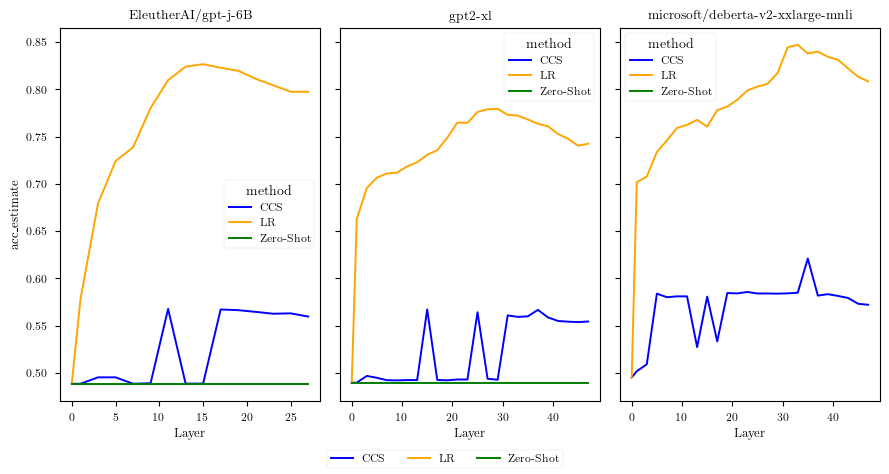

Ensembling: none


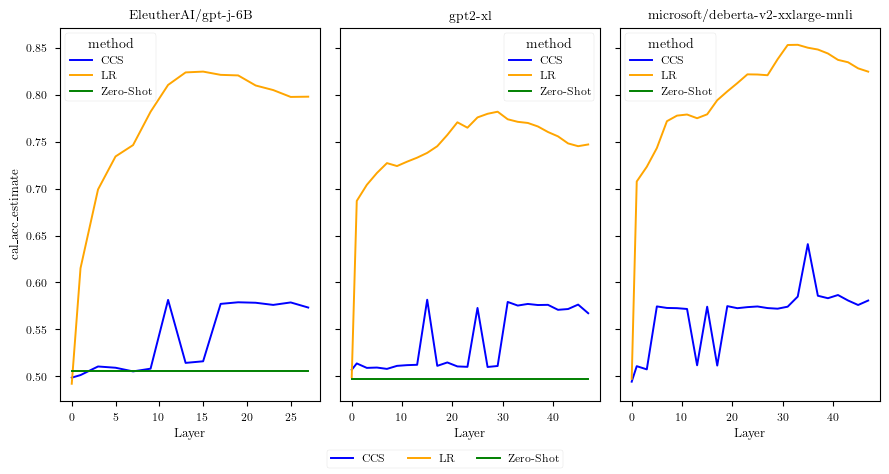

Ensembling: none


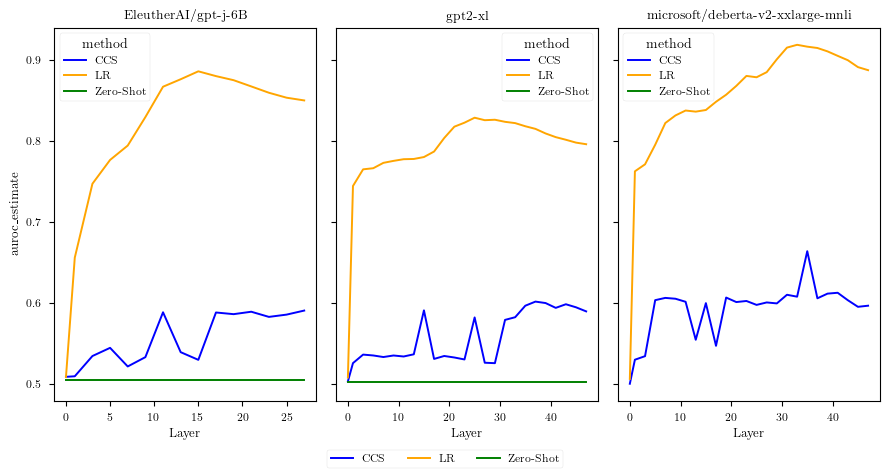

Ensembling: none


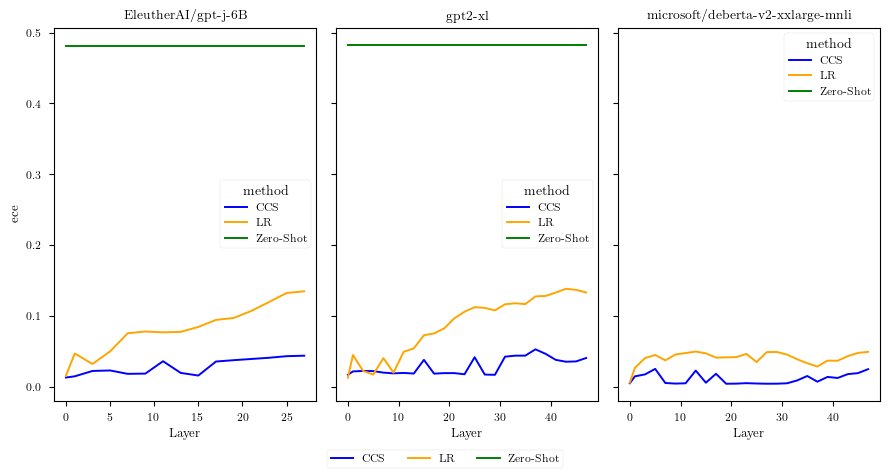

Ensembling: partial


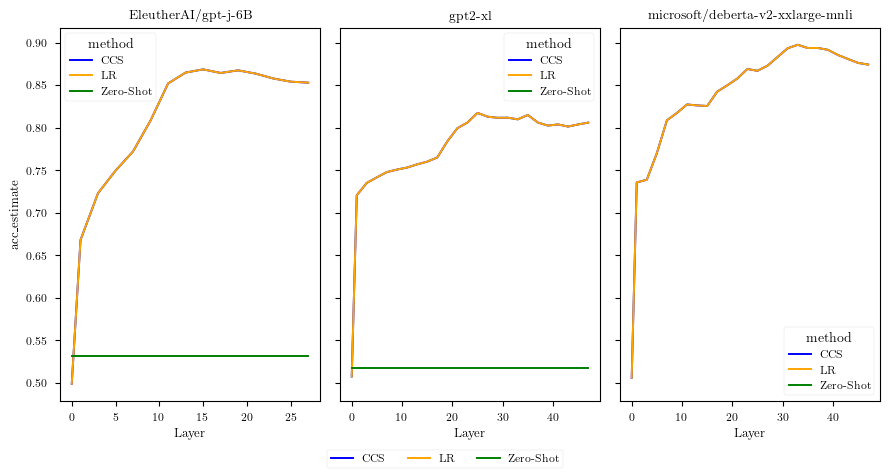

Ensembling: partial


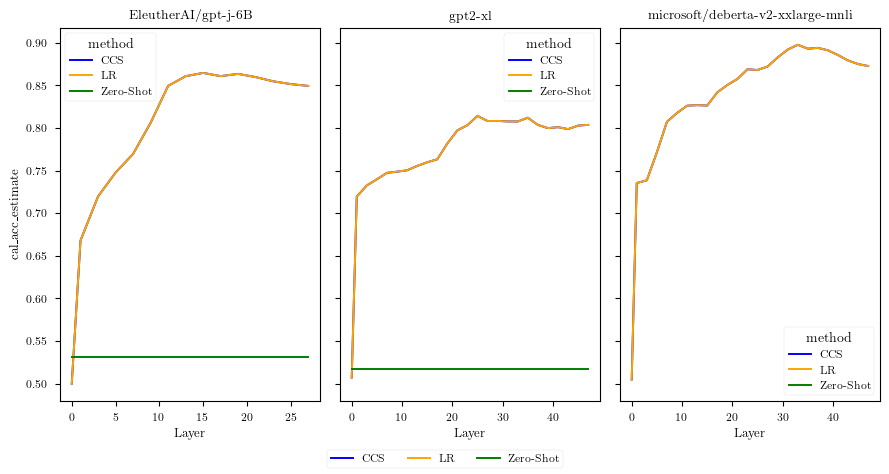

Ensembling: partial


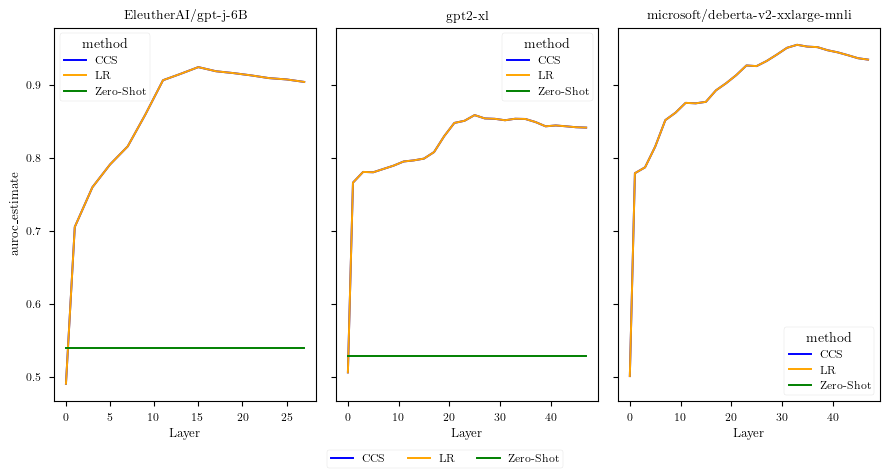

Ensembling: partial


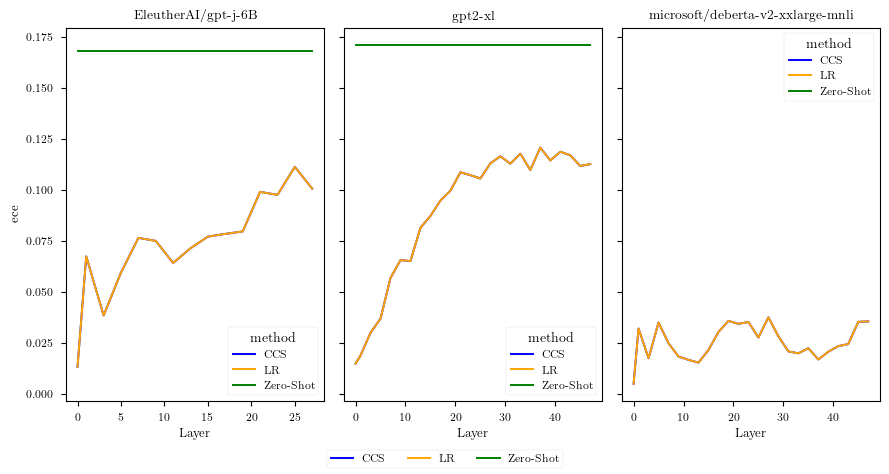

Ensembling: full


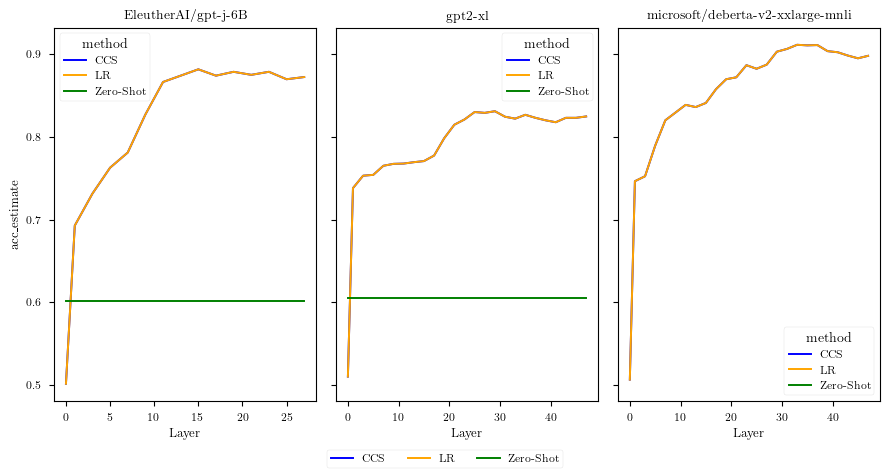

Ensembling: full


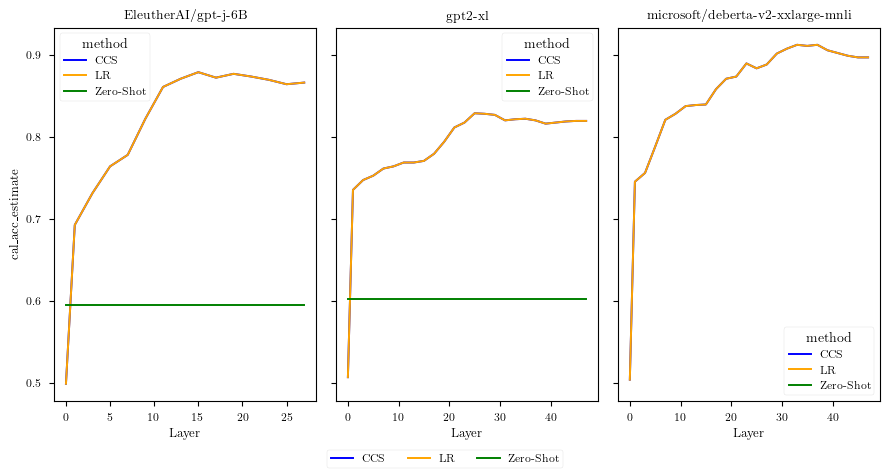

Ensembling: full


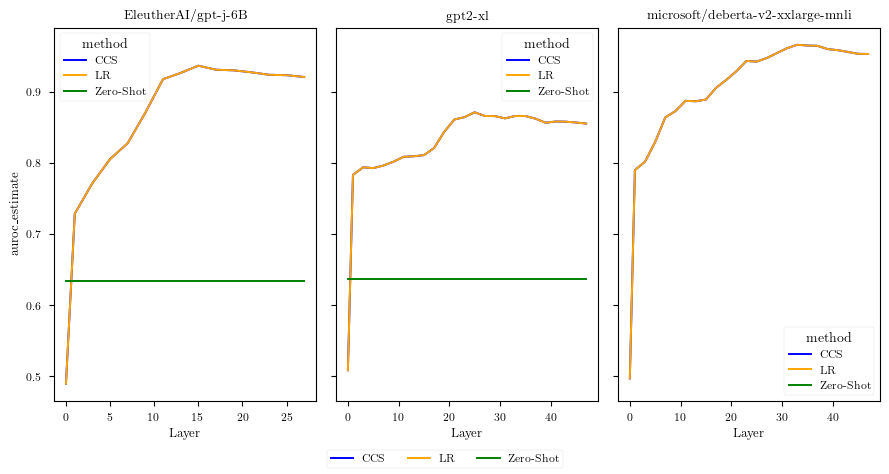

Ensembling: full


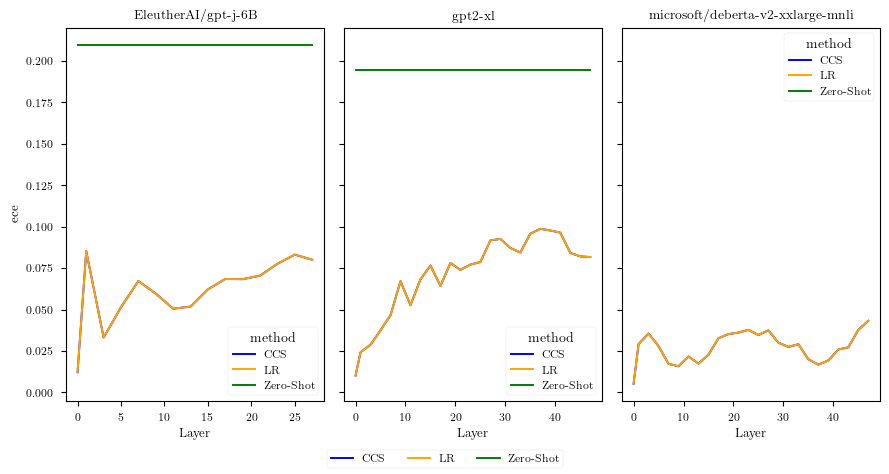

In [236]:
for ensembling in ["none", "partial", "full"]:
    for metric in ["acc_estimate", "cal_acc_estimate", "auroc_estimate", "ece"]:
        print(f"Ensembling: {ensembling}")
        plot_metric_vs_layer(
            results_df_without_transfer, ensembling=ensembling, metric=metric
        )


In [259]:
def generate_heatmaps(df, metric_name: str, layer=None, ensembling=None):
    # Validate metric name
    metric_options = ["acc_estimate", "cal_acc_estimate", "auroc_estimate", "ece"]
    if metric_name not in metric_options:
        raise ValueError(f"Invalid metric. Must be one of {metric_options}")
    # If layer is specified, filter by layer
    if layer is not None:
        df = df[
            (df["eval_layer"] == layer)
            & (df["lr_eval_layer"] == layer)
            & (df["lm_eval_layer"] == layer)
        ]
    # If ensembling is specified, filter by ensembling
    if ensembling is not None:
        df = df[
            (df["eval_ensembling"] == ensembling)
            & (df["lr_eval_ensembling"] == ensembling)
            & (
                (df["lm_eval_ensembling"] == ensembling)
                | df["lm_eval_ensembling"].isna()
            )
        ]
    # Group by model, training dataset, and eval dataset.
    grouped_df = df.groupby(["model", "dataset", "eval_dataset"])
    # Take the min if ECE, max if accuracy or AUROC.
    grouped_df = grouped_df.min() if metric_name == "ece" else grouped_df.max()
    grouped_df = grouped_df.reset_index()

    # Define CCS and LR column suffixes
    ccs_suffix = f"eval_{metric_name}"
    lr_suffix = f"lr_eval_{metric_name}"

    # Get unique models and datasets
    models = grouped_df["model"].unique()
    datasets = grouped_df["dataset"].unique()

    # Create figure with n rows and 2 columns
    fig, axes = plt.subplots(nrows=len(models), ncols=2, figsize=(10, 5 * len(models)))
    fig.suptitle(
        f"Heatmaps of Transfer Accuracy for {metric_name.capitalize()}", fontsize=16
    )

    for i, model in enumerate(models):
        for j, suffix in enumerate([ccs_suffix, lr_suffix]):
            # Filter dataframe for the current model
            model_df = grouped_df[grouped_df["model"] == model]

            # Create pivot table for heatmap
            heatmap_data = model_df.pivot_table(
                index="dataset", columns="eval_dataset", values=suffix, aggfunc="mean"
            )

            # Create heatmap
            ax = axes[i, j] if len(models) > 1 else axes[j]
            sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis", ax=ax)
            ax.set_title(f'{model} - {"CCS" if j == 0 else "LR"}')
            ax.set_xlabel("Eval Dataset")
            ax.set_ylabel("Training Dataset")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


Ensembling: none


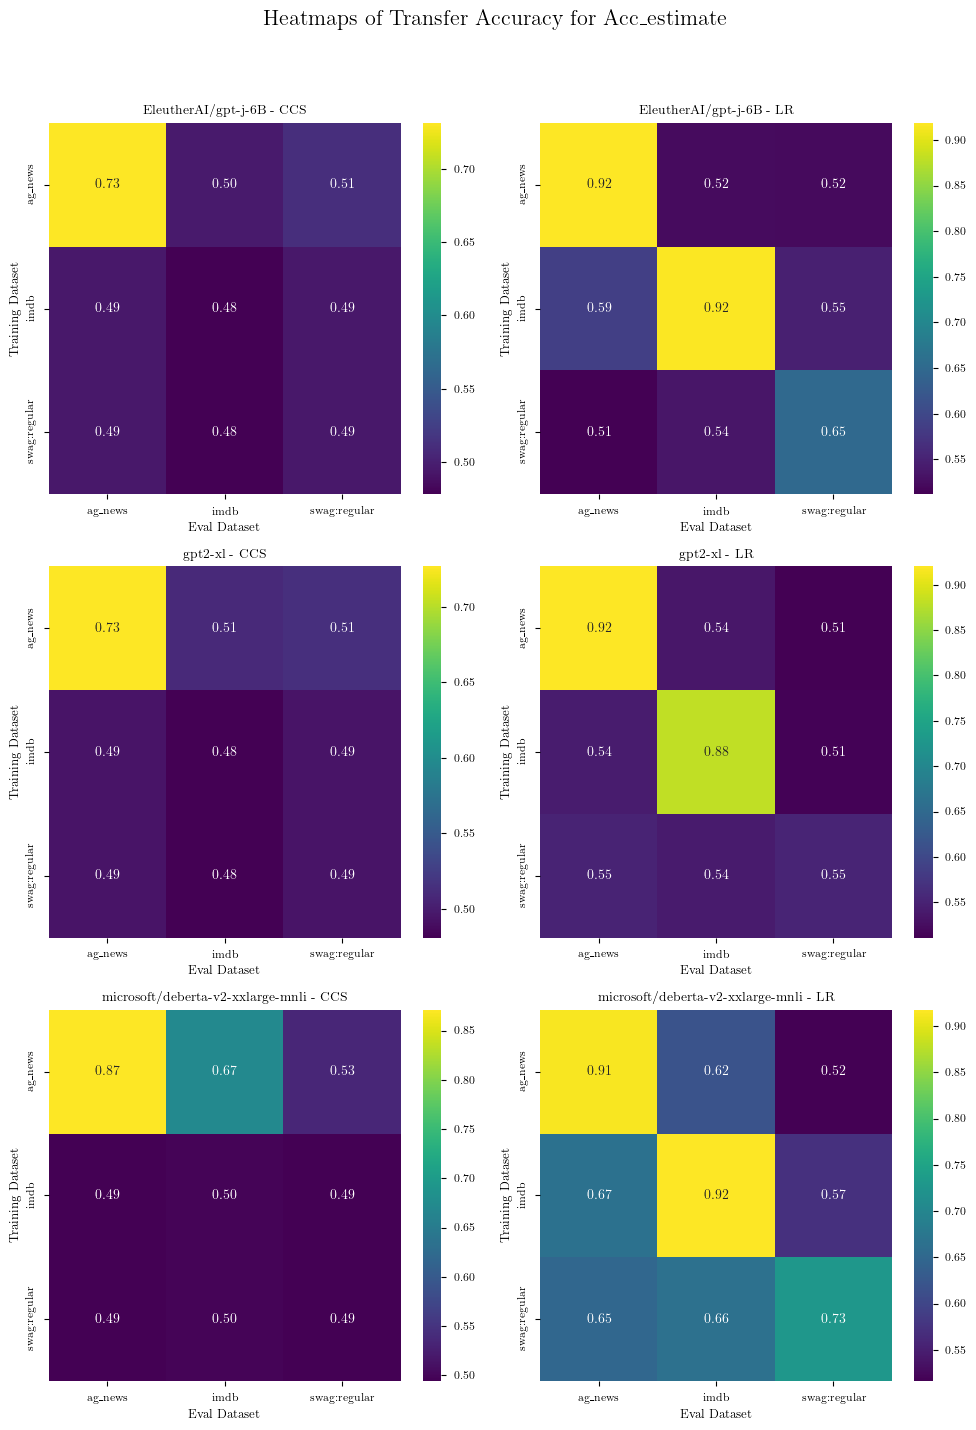

Ensembling: none


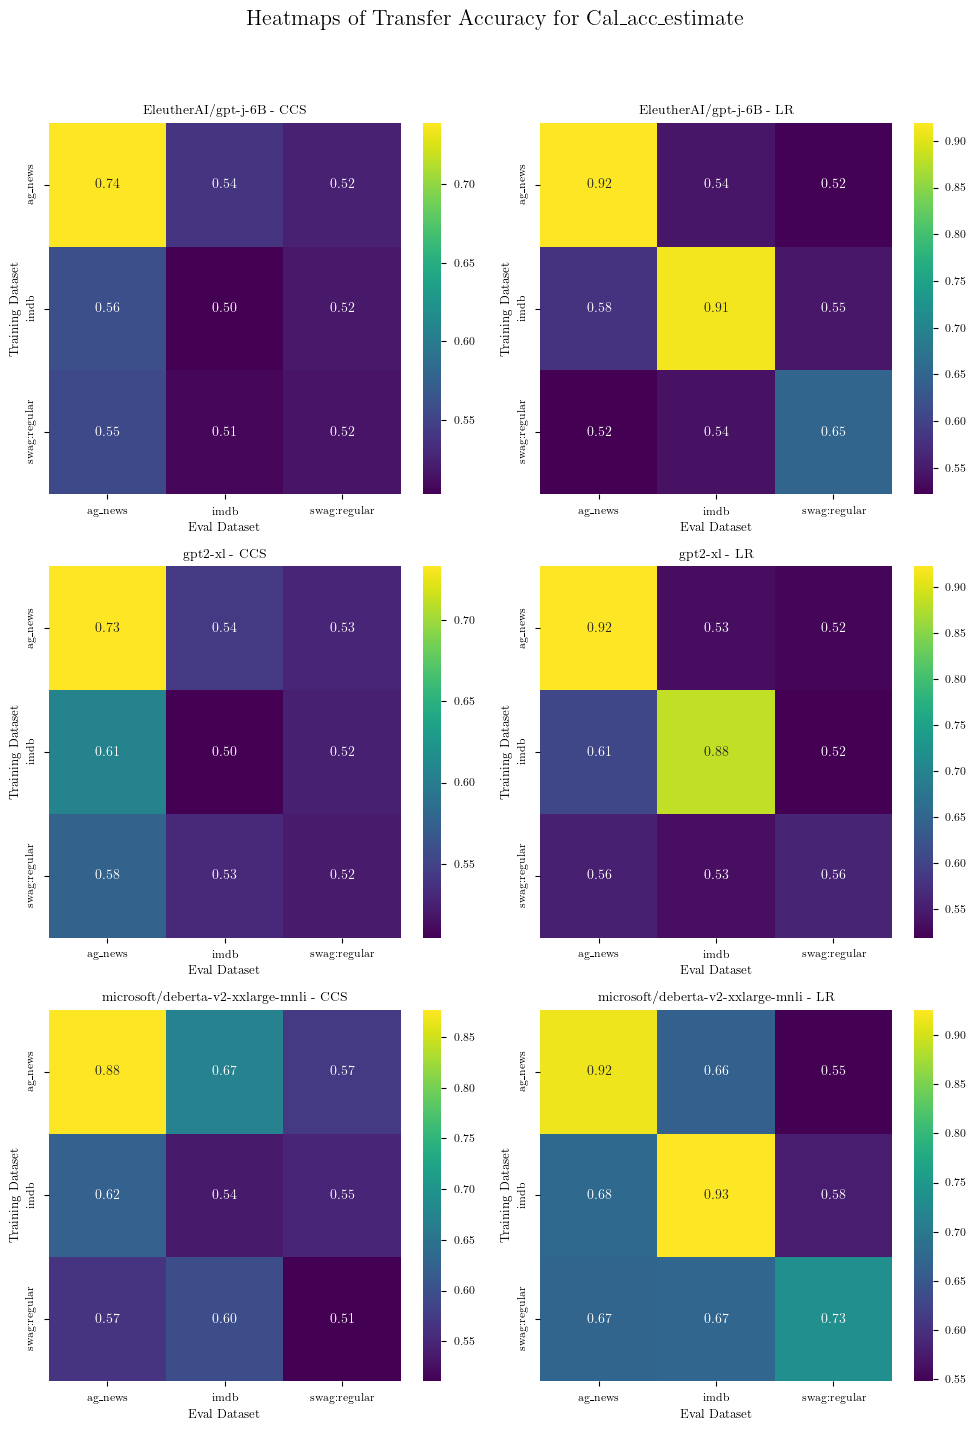

Ensembling: none


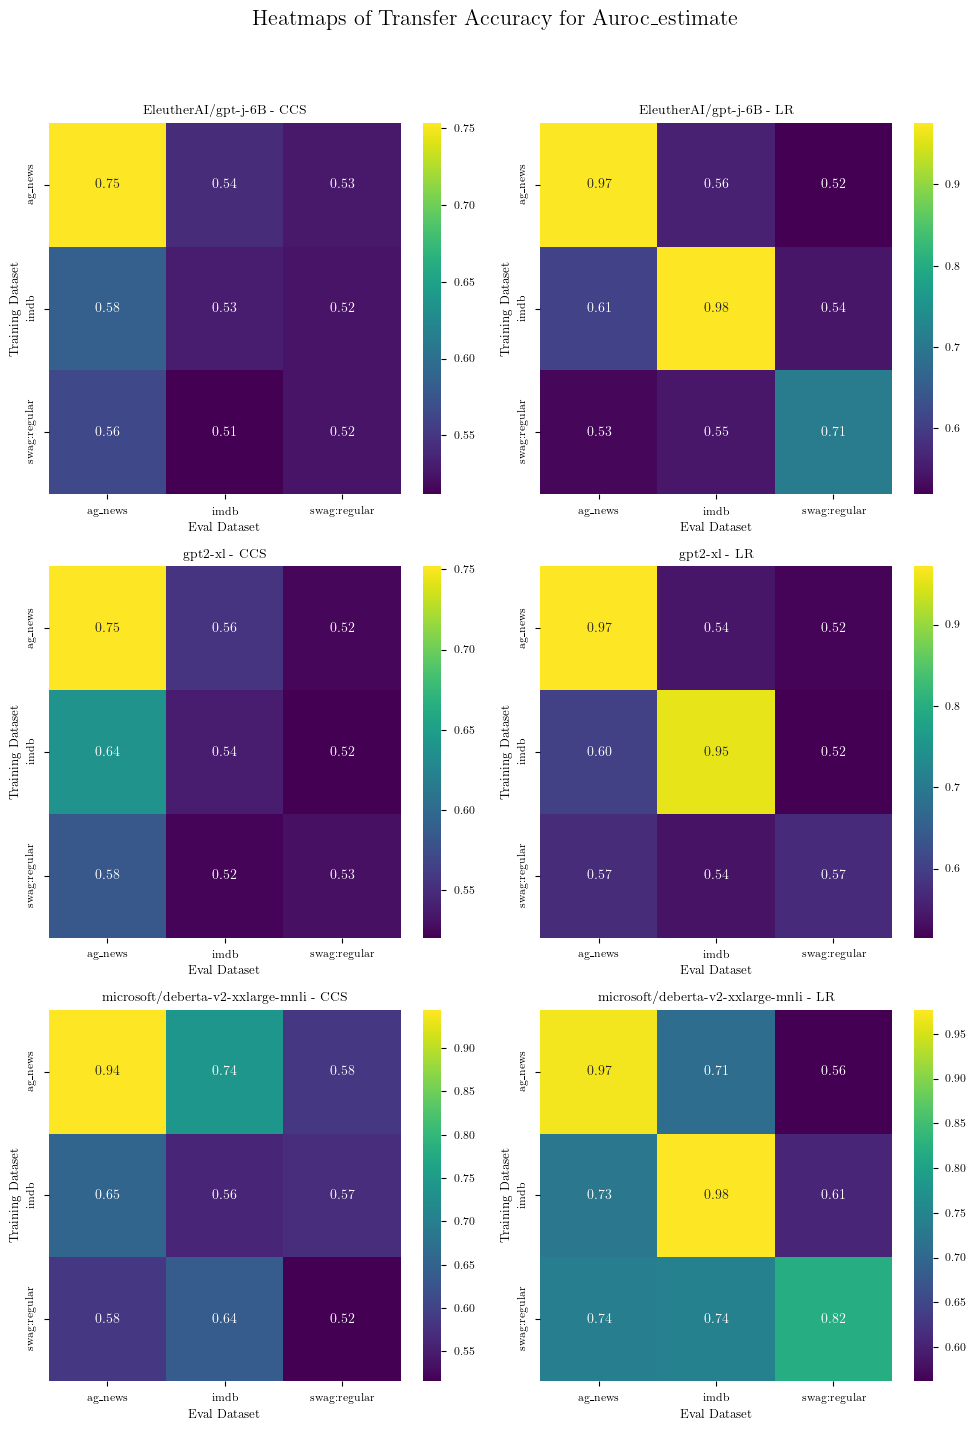

Ensembling: none


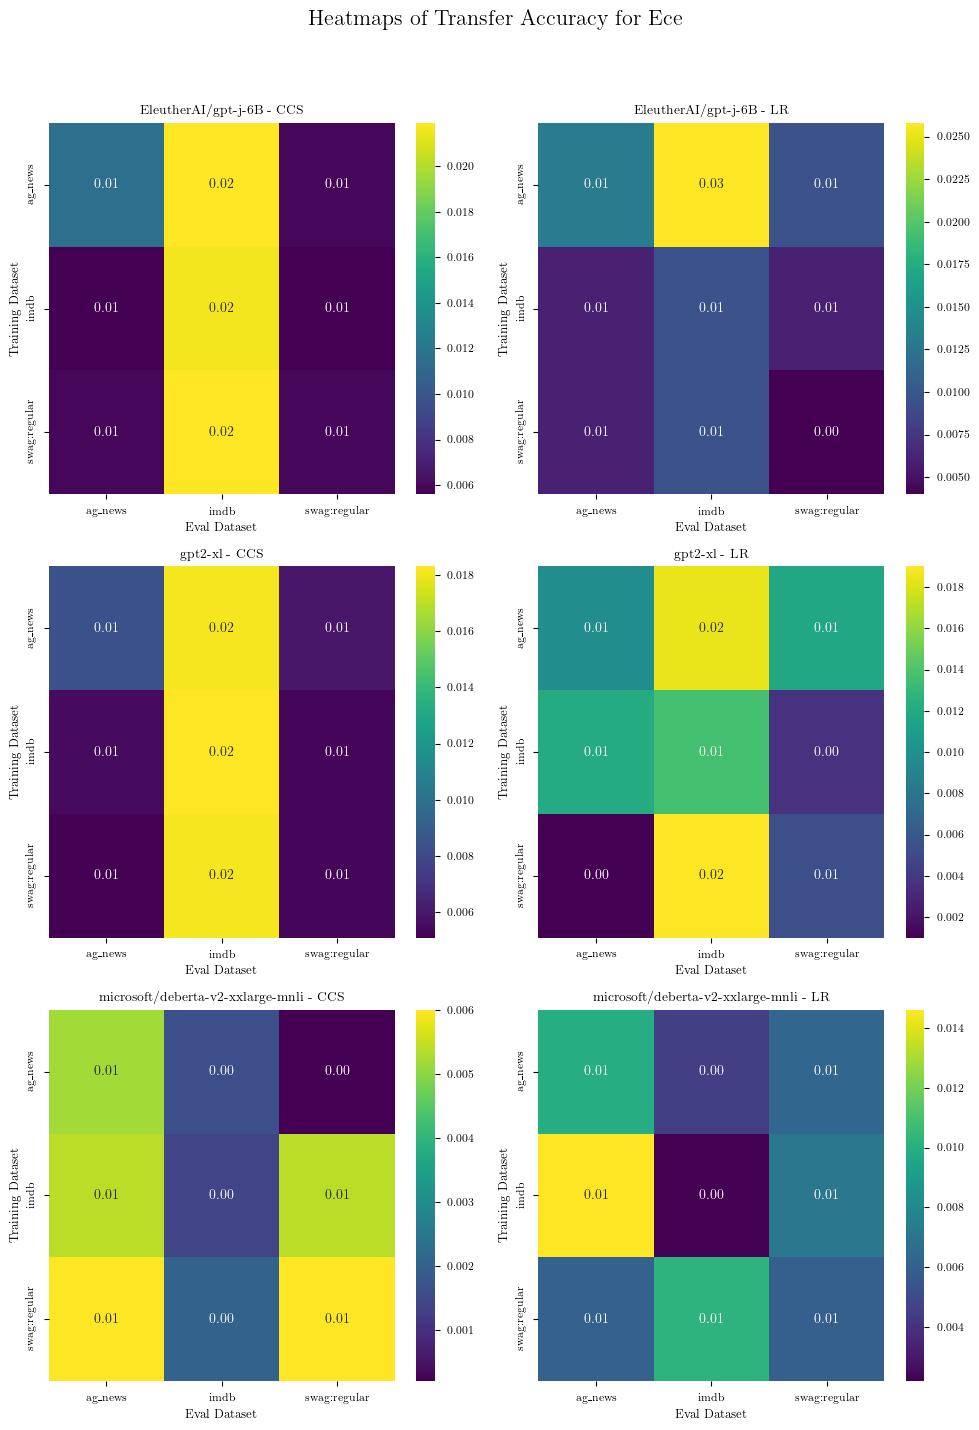

Ensembling: partial


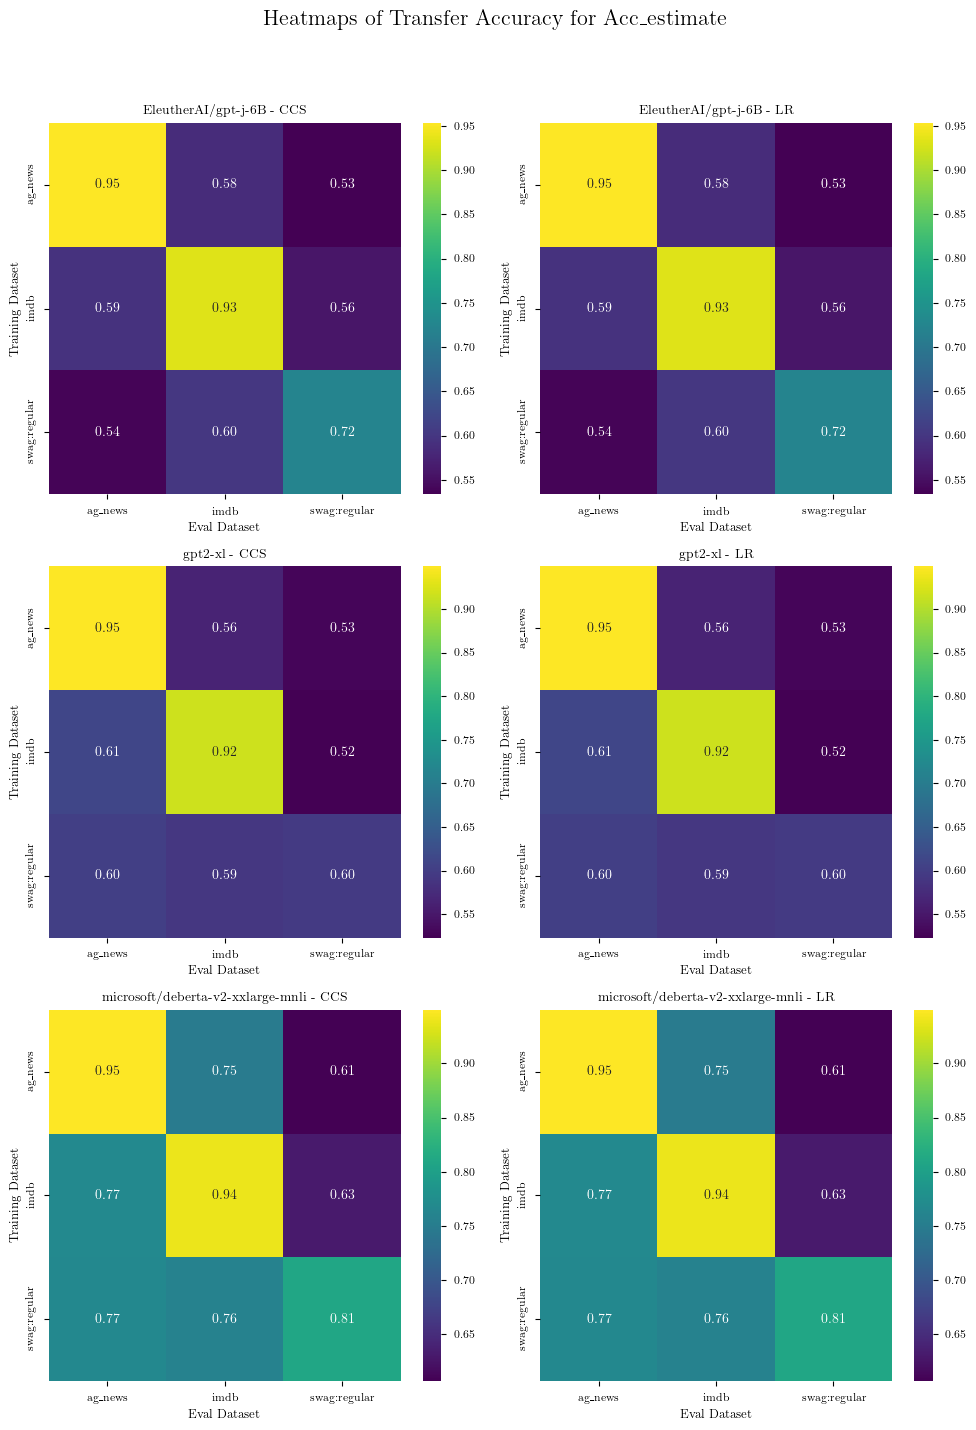

Ensembling: partial


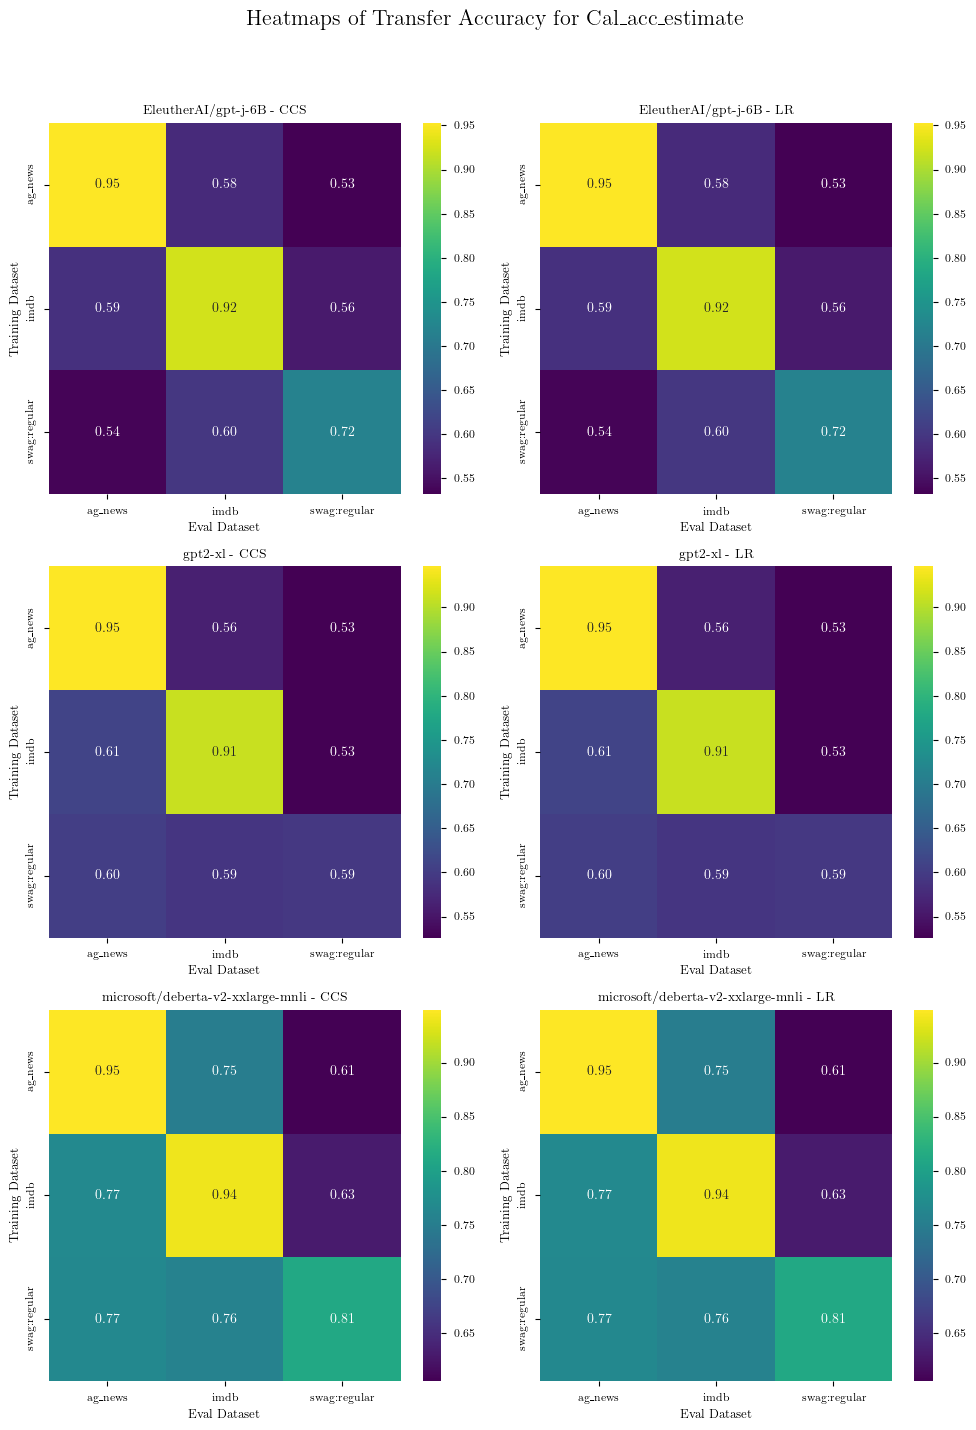

Ensembling: partial


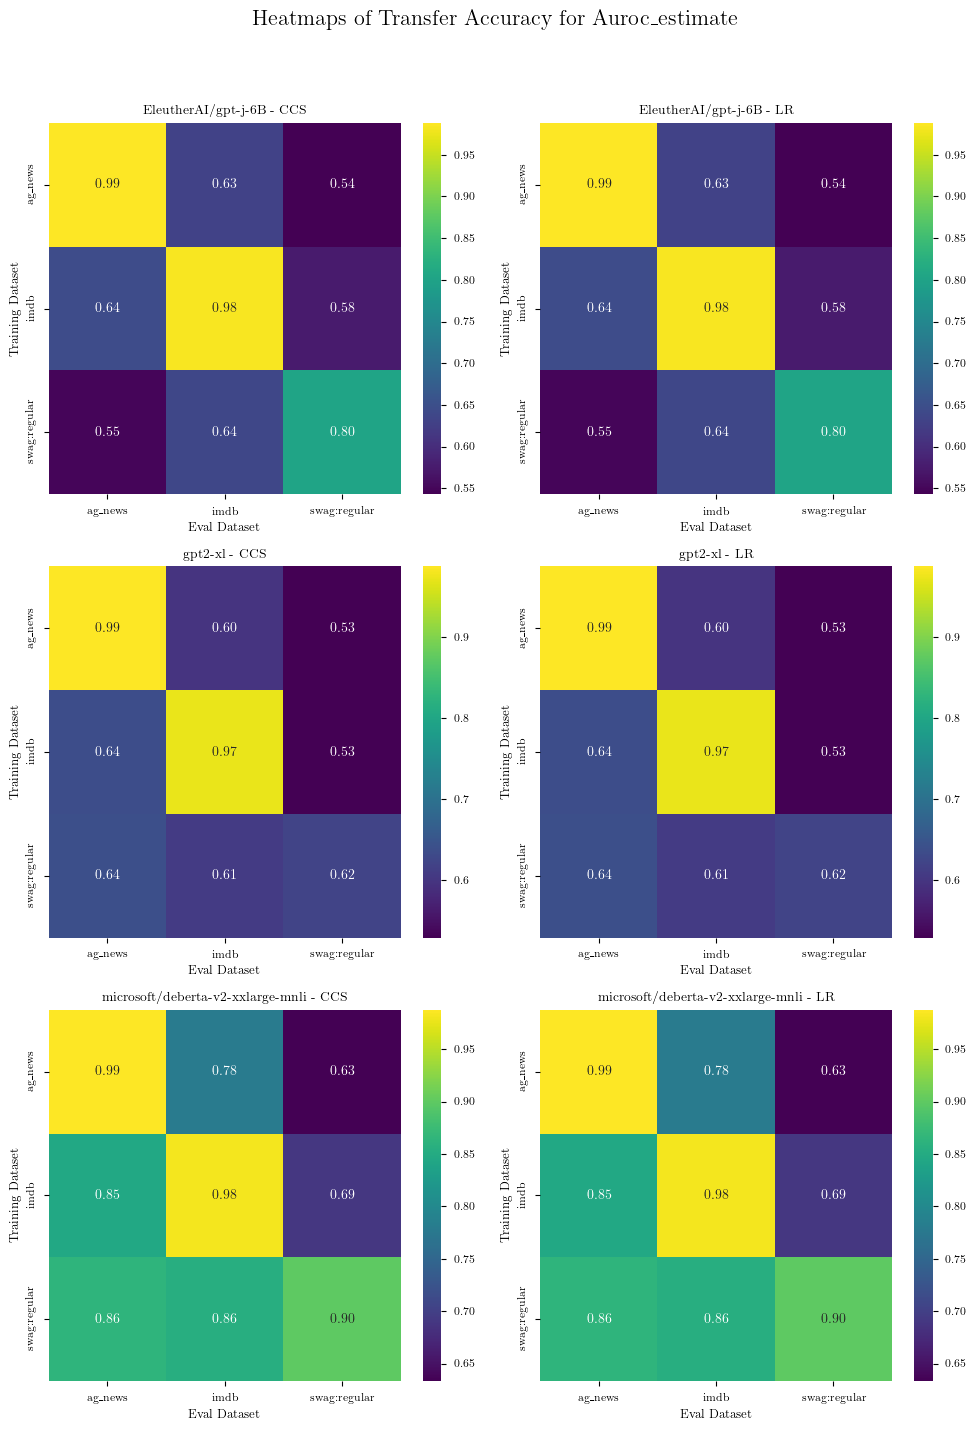

Ensembling: partial


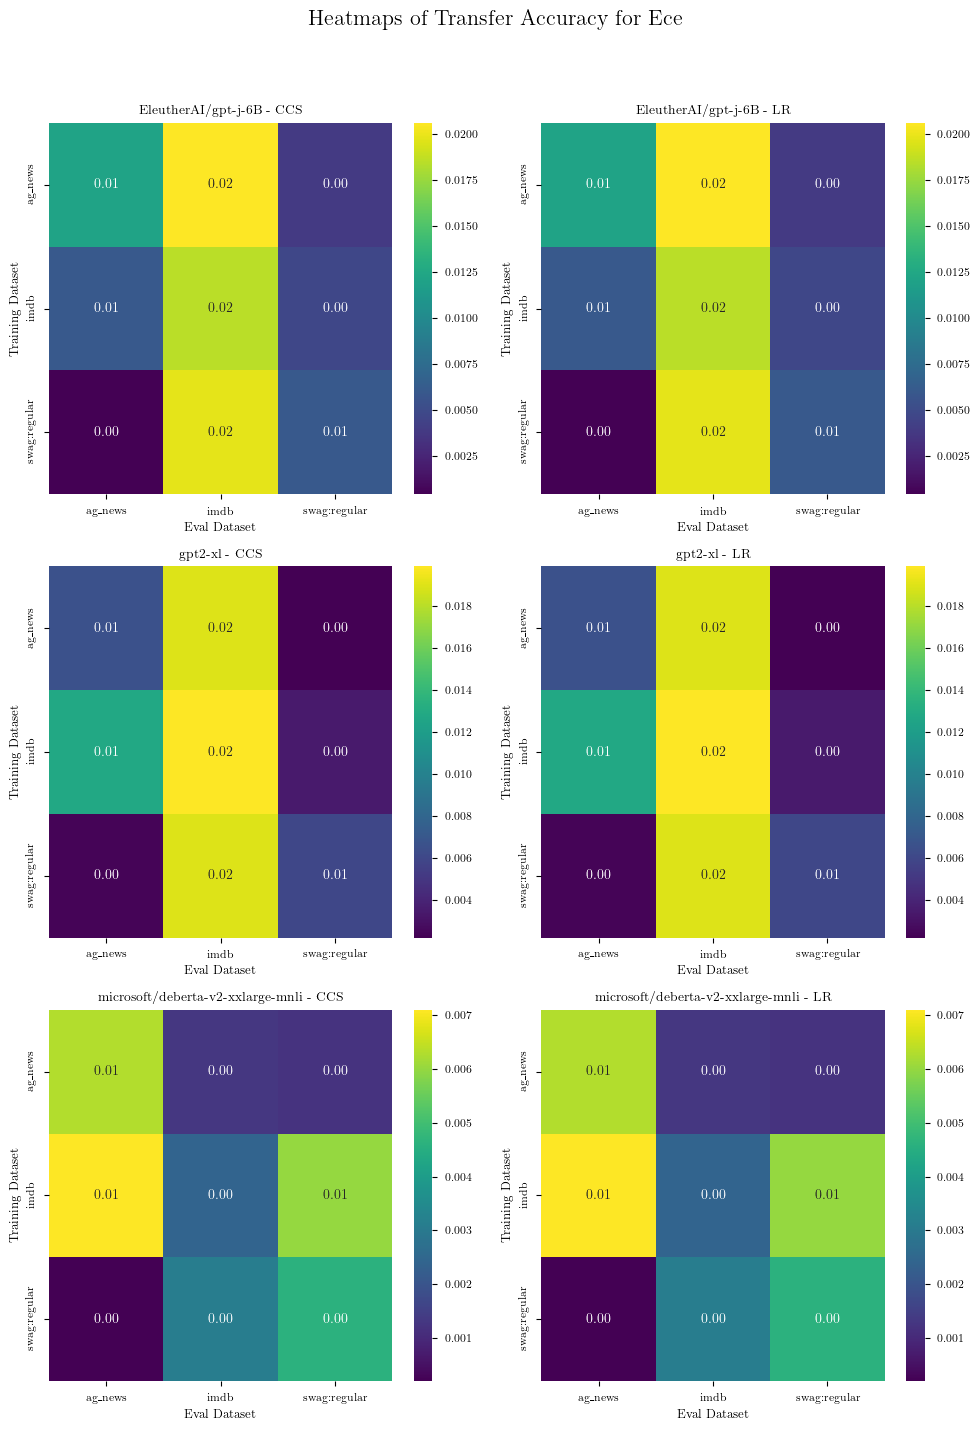

Ensembling: full


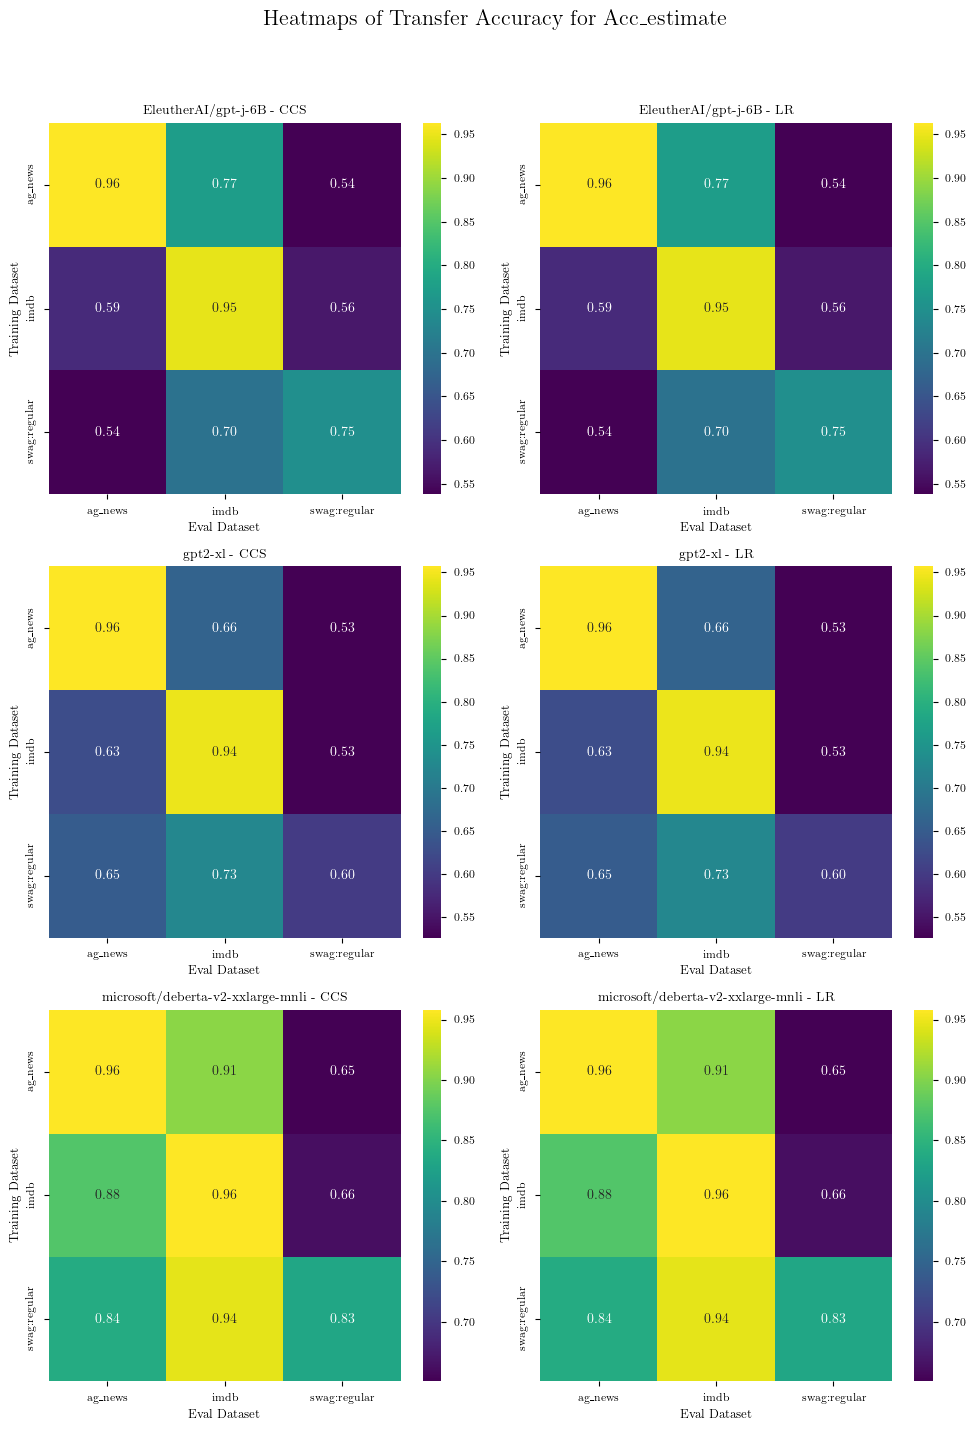

Ensembling: full


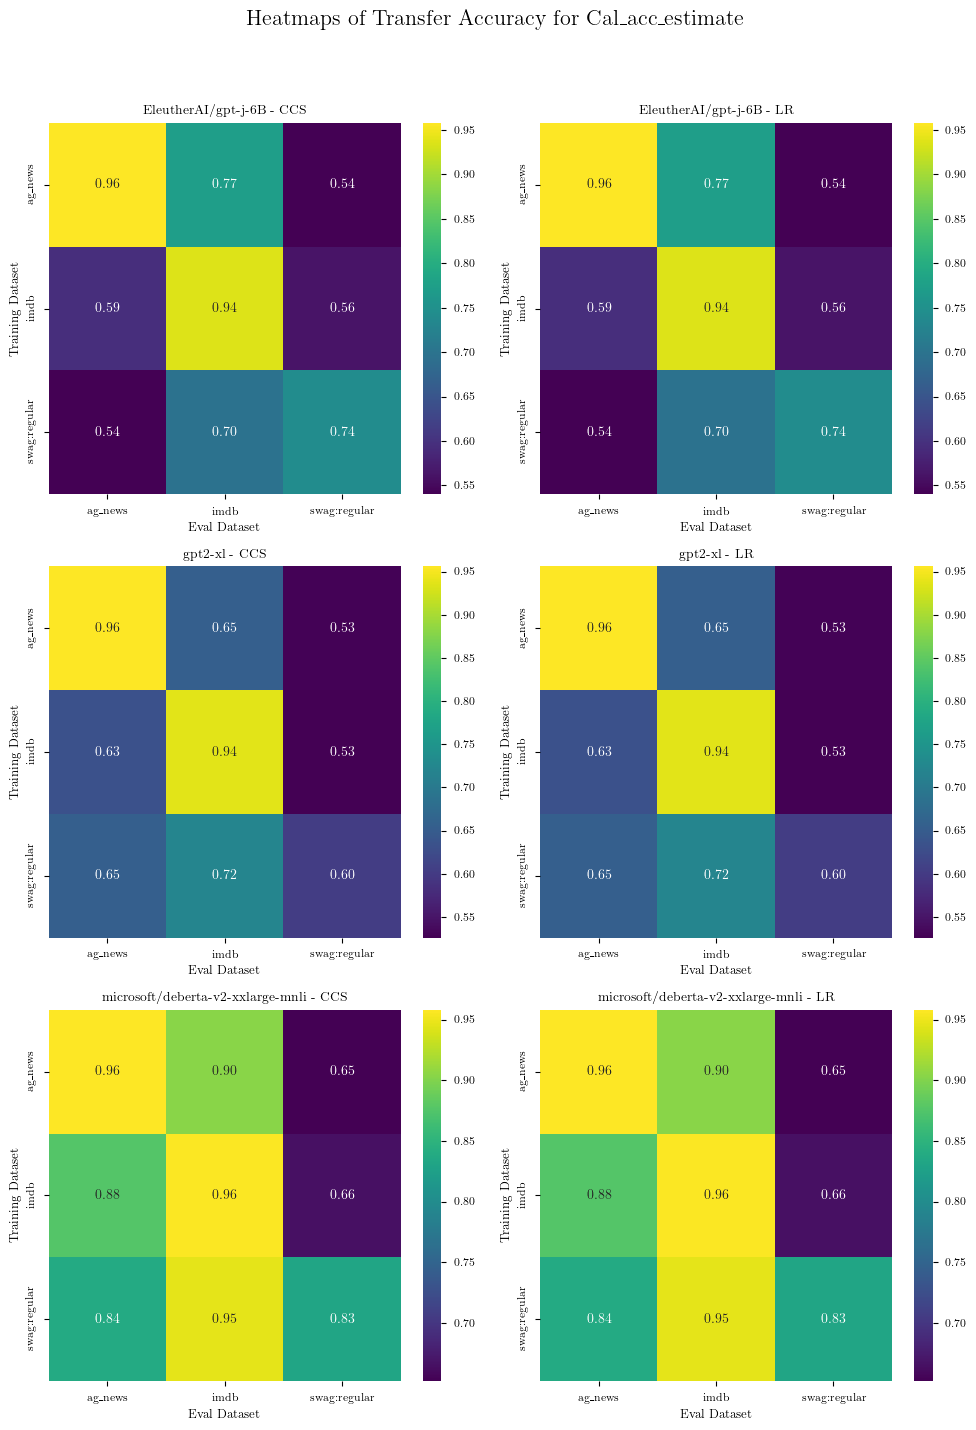

Ensembling: full


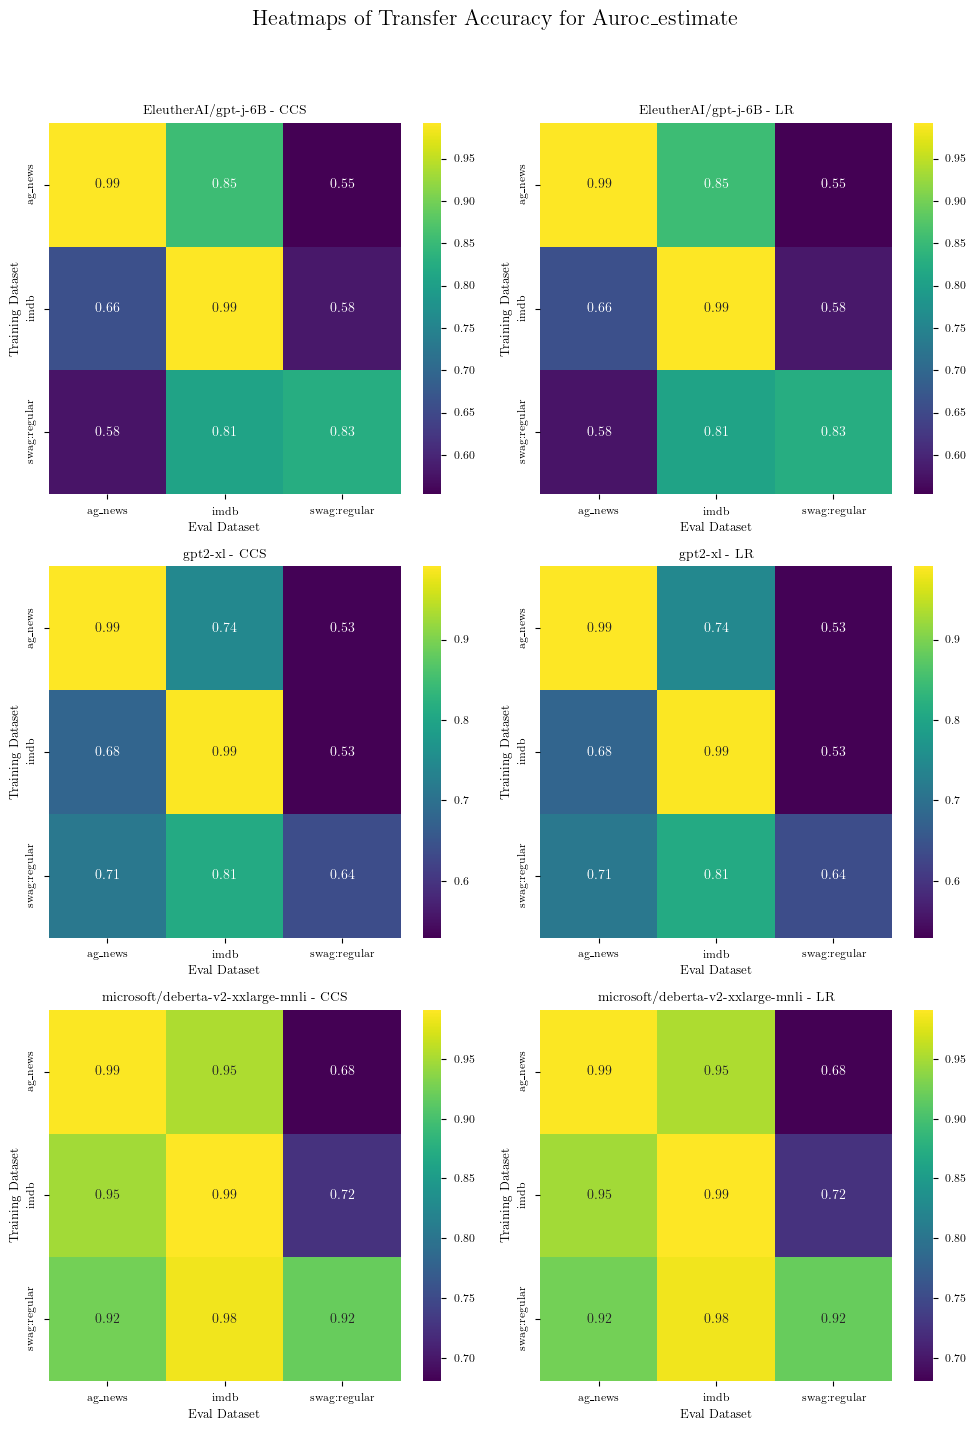

Ensembling: full


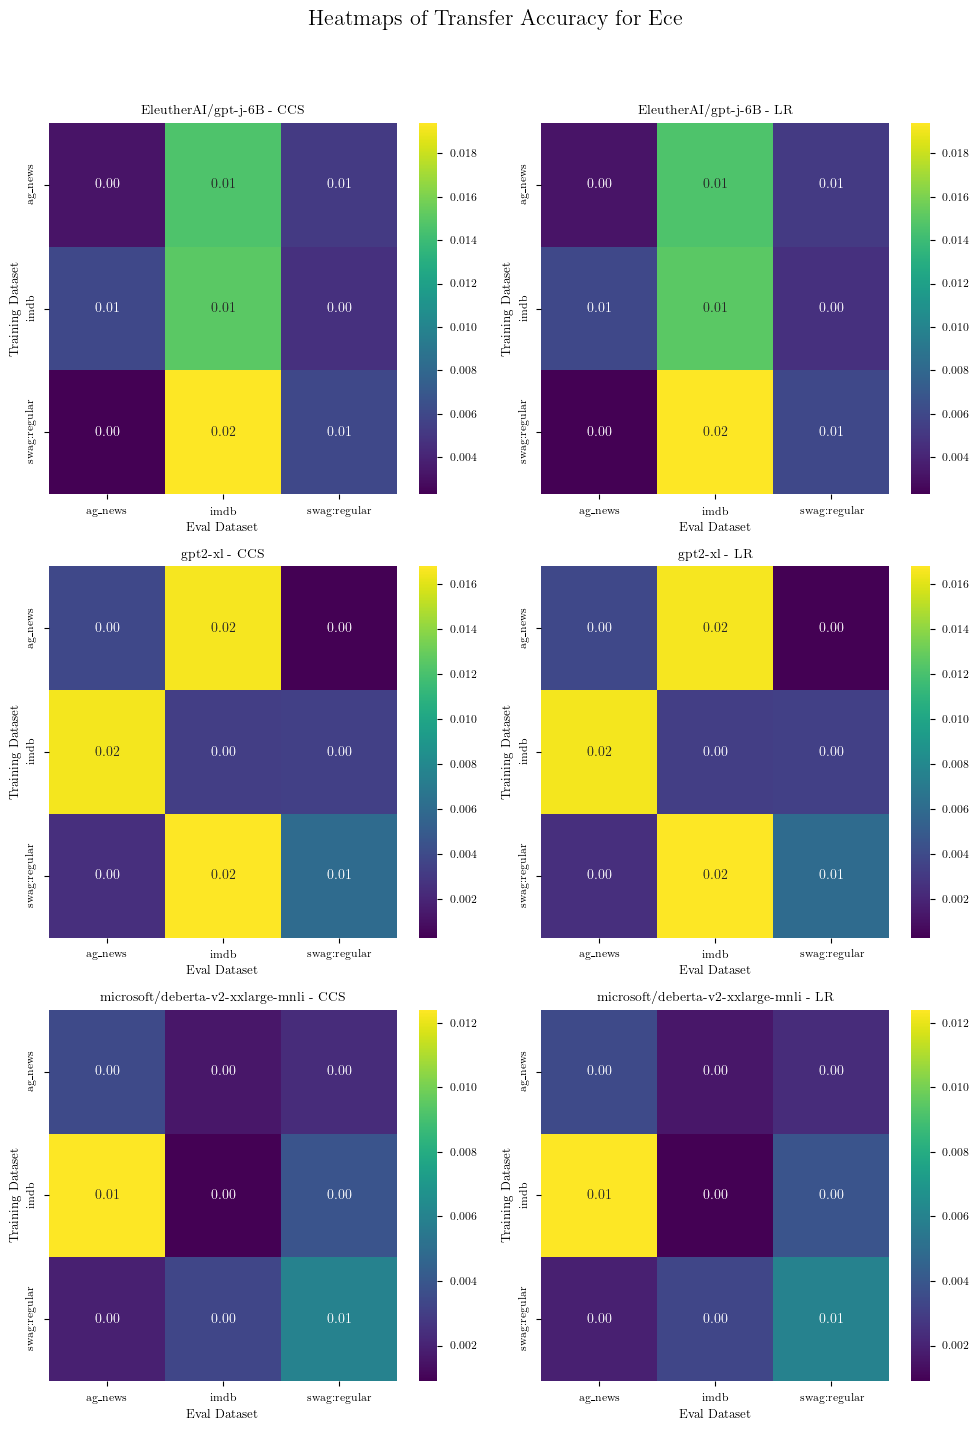

In [263]:
for ensembling in ["none", "partial", "full"]:
    for metric in ["acc_estimate", "cal_acc_estimate", "auroc_estimate", "ece"]:
        print(f"Ensembling: {ensembling}")
        generate_heatmaps(results_df, metric, layer=None, ensembling=ensembling)
